In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import h5py
from torch.cuda.amp import autocast, GradScaler
from torch.nn.utils import weight_norm

import os

#from load_data import get_model_data

nor_sta_fes1 = torch.from_numpy(pd.read_csv('./data/nor_su_static.csv').to_numpy().astype('float32'))
nor_sta_fes1.shape

/home/jovyan/anaconda3/envs/cgnn/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch.Size([89, 11])

In [6]:
dys1= torch.from_numpy(np.load('./data/nor_8_dy_series.npy').astype('float32'))
ys1 = torch.from_numpy(pd.read_csv('./data/nor_EWM_deform_60.csv').T.to_numpy().astype('float32'))


exclude_ids = [2,5,13,37,53,56]
indices = list(range(nor_sta_fes1.size(0)))
# 排除指定的索引
indices = [i for i in indices if i not in exclude_ids]

nor_sta_fes = nor_sta_fes1[indices]
dys = dys1[:,:,:,indices]
ys = ys1[:,indices]

x_train = dys[:70]
x_test = dys[70:]
y_train = ys[:70]
y_test = ys[70:]

dys.shape

torch.Size([83, 8, 90, 83])

In [8]:
class OutputLayerWithAttention(nn.Module):
    def __init__(self, c, T, n):
        super(OutputLayerWithAttention, self).__init__()
        self.tconv1 = nn.Conv2d(c, c, (T, 1), 1, dilation=1, padding=(0, 0))
        self.relu3 = nn.ReLU()
        self.drop3 = nn.Dropout(0.5)
        self.ln = nn.LayerNorm([n, c])
        self.tconv2 = nn.Conv2d(c, c, (1, 1), 1, dilation=1, padding=(0, 0))
        self.relu4 = nn.ReLU()
        self.drop4 = nn.Dropout(0.5)
        self.fc = FullyConvLayer(c)

        # Transformer-Style Attention
        self.attention = nn.MultiheadAttention(embed_dim=c, num_heads=4, batch_first=True)

    def forward(self, x):
        x_t1 = self.relu3(self.tconv1(x))  # [batch_size, channels, height, width]
        x_t1 = self.drop3(x_t1)

        x_ln = self.ln(x_t1.permute(0, 2, 3, 1)).permute(0, 3, 1, 2)  # Layer normalization

        # Attention applied to the last two dimensions
        batch, channels, height, width = x_ln.size()
        x_reshaped = x_ln.view(batch, channels, -1).permute(0, 2, 1)  # [batch, seq_len, channels]
        attn_output, _ = self.attention(x_reshaped, x_reshaped, x_reshaped)  # Apply attention
        x_t2 = attn_output.permute(0, 2, 1).view(batch, channels, height, width)

        x_t2 = self.relu4(self.tconv2(x_t2))
        x_t2 = self.drop4(x_t2)

        return self.fc(x_t2)

In [9]:
class Chomp2d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp2d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        """
        裁剪的模块，裁剪多出来的padding
        """
        return x[:, :, :-self.chomp_size[0], :-self.chomp_size[1]].contiguous()
    
class FullyConvLayer(nn.Module):
    def __init__(self, c):
        super(FullyConvLayer, self).__init__()
        self.conv = nn.Conv2d(c, 1, 1)

    def forward(self, x):
        return self.conv(x)


class OutputLayer(nn.Module):
    def __init__(self, c, T, n):
        super(OutputLayer, self).__init__()
        self.tconv1 = nn.Conv2d(c, c, (T, 1), 1, dilation=1, padding=(0, 0))
        self.relu3 = nn.ReLU()
        self.drop3 = nn.Dropout(0.5)
        self.ln = nn.LayerNorm([n, c])
        self.tconv2 = nn.Conv2d(c, c, (1, 1), 1, dilation=1, padding=(0, 0))
        self.relu4 = nn.ReLU()
        self.drop4 = nn.Dropout(0.5)
        self.fc = FullyConvLayer(c)
        
        

    def forward(self, x):
        x_t1 = self.relu3(self.tconv1(x))  #out[7, 64, 14, 4398]
        #print(x_t1.shape)
        x_t1 = self.drop3(x_t1)
        
        x_ln = self.ln(x_t1.permute(0, 2, 3, 1)).permute(0, 3, 1, 2)
        #print(x_ln.shape)  #[7, 64, 14, 4398]
        x_t2 = self.relu4(self.tconv2(x_ln))
        x_t2 = self.drop4(x_t2) #same size with x_ln

        return self.fc(x_t2)    



class TN_module(nn.Module):
    def __init__(self, c_in, c_out, dropout, dia=1):
        super(TN_module, self).__init__()
        
        self.conv1 = weight_norm(nn.Conv2d(c_in, c_out, (3,1),
                                           stride=1, padding=(0,0), dilation=dia))
        # 经过conv1，输出的size其实是(Batch, input_channel, seq_len + padding)
        self.dropout1 = nn.Dropout(dropout)
        self.chomp1 = Chomp2d((2,0))  # 裁剪掉多出来的padding部分，维持输出时间步为seq_len
        self.relu1 = nn.ReLU()
        
        self.conv2 = nn.Conv2d(
            c_out, c_out, (3, 1), 1, dilation=2, padding=(0, 0)
        )  #（2，1）卷积核的尺寸
        self.dropout2 = nn.Dropout(dropout)
        self.relu2 = nn.ReLU()
        
        self.conv3 = nn.Conv2d(
            c_out, c_out, (3, 1), 1, dilation=4, padding=(0, 0)
        )  #（2，1）卷积核的尺寸
                
        self.dropout3 = nn.Dropout(dropout)
        self.relu3 = nn.ReLU()
        
        self.net = nn.Sequential(self.conv1, self.relu1, self.dropout1,
                                 self.conv2,self.relu2, self.dropout2,
                                self.conv3,self.relu3, self.dropout3,)
        self.init_weights()
        
        self.fc1 = nn.Linear(11,24)
        self.relu = nn.ReLU()
        self.drop1 = nn.Dropout(dropout)
        self.out = OutputLayer(24+c_out, 76, 83)  #18,14
        #self.out = OutputLayerWithAttention(24+c_out, 76, 83)  #18,14
        
    
    def init_weights(self):
        """
        参数初始化
        """
        self.conv1.weight.data.normal_(0, 0.01)
    
    def forward(self, x1,x2):
        
        x1 = self.net(x1)   #[79,7,46,269]
        #x2 = x2.view((13,-1))  #[269,13]
        x2 = self.relu(self.fc1(x2))
        x2 = self.drop1(x2).T
        
        x2 = x2.unsqueeze(0)
        x2 = x2.unsqueeze(2)
        x2 = x2.repeat(x1.shape[0],1,x1.shape[2],1)
        #print(x2.shape)
        #print(x2.shape)
        out = torch.cat((x1, x2), dim=1)
        #print(out.shape)
        # Output layer
        #print(out.shape)
        out = self.out(out).squeeze(1)
        
        return out.squeeze(1)
    
#x2 = x2.unsqueeze(2).repeat(1, 1,x1.shape[2], 1)  ##(2,32,1,23140) --->(2,32,28,23140) 

def torch_corre(y_pre,y_true):
    y_pre = y_pre.view((-1,))
    y_true = y_true.view((-1,))
    #print(y_pre.shape,y_true.shape)
    stacked = torch.stack((y_true, y_pre))
    
    # 计算相关系数矩阵
    corr_matrix = torch.corrcoef(stacked)
    
    # 提取皮尔逊相关系数
    pearson_coefficient = corr_matrix[0, 1]
    
    return pearson_coefficient

In [10]:
class WMSE_loss(nn.Module):
    def __init__(self):
        super(WMSE_loss,self).__init__()
    def forward(self,y_pred,y_true):
        
        mean_w = torch.mean(y_true)
        #y_true1 = torch.where(y_true>0.98, y_true*2, y_true*0.5)

        #error = torch.mean(2**(-abs(y_true))*(y_true - y_pred)**2/(2**(-mean_w)))
        error = torch.mean(abs(y_true)*(y_true - y_pred)**2/mean_w)
        return error

In [11]:
#ex_list = [330,48,21736,18900,11814,22401]
device = torch.device("cuda:0")
#device = torch.device("cpu")
nor_sta_fes = nor_sta_fes.to(device)
x_train = x_train.to(device)
x_test = x_test.to(device)

batch_size = 12
train_data = torch.utils.data.TensorDataset(x_train, y_train)
train_iter = torch.utils.data.DataLoader(train_data, batch_size, shuffle=True)

val_data = torch.utils.data.TensorDataset(x_test, y_test)
val_iter = torch.utils.data.DataLoader(val_data, batch_size)
vals = []

tcn = TN_module(c_in = 8, c_out = 64, dropout = 0.5).to(device)

In [16]:
#tcn = TCN(num_inputs, num_channels, kernel_size, dropout).to(device)
tcn = TN_module(c_in = 8, c_out = 128, dropout = 0.5).to(device)
#print(tcn)
#criterion = nn.MSELoss()  # 均方误差损失函数
#optimizer = torch.optim.Adam(tcn.parameters(), lr=0.004,weight_decay = 5e-5)  # Adam优化器
     
loss = nn.MSELoss()
#loss = WMSE_loss()
model_pth = './results/attention/dy11_EWM_TCN_0.6672.pth'
tmp_pcc = 0.667
for j in range(50):
    #tmp_pcc = 0.66
    #tcn = TN_module(c_in = 8, c_out = 64, dropout = 0.5).to(device)
    tcn.load_state_dict(torch.load(model_pth))
    optimizer = torch.optim.Adam(tcn.parameters(), lr=0.0005*0.8**j,weight_decay = 5e-5)
    if j<30:
        loss = nn.MSELoss()
    else:
        loss = WMSE_loss()
    for epoch in range(1, 30+1):
        #loss = nn.MSELoss()
        #loss = WMSE_loss()
        #scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.85)
        l_sum, n = 0.0, 0
        tcn.train()
        for x, y in train_iter:
            x, y= x.to(device), y.to(device)
            y_pred = tcn(x,nor_sta_fes)
            #print(y_pred.shape,y.shape)
            l = loss(y_pred, y)
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            l_sum += l.item() * y.shape[0]
            n += y.shape[0]
        #scheduler.step()

        tcn.eval()
        val_pre = tcn(x_test,nor_sta_fes).cpu()

        val_loss = torch_corre(val_pre,y_test)
        val_mae = torch.mean(abs(val_pre-y_test))
        if val_loss>tmp_pcc and l_sum/n<0.01 and val_pre.max()>1.0:
            tmp_pcc = val_loss+0.001
            print('----------------------------',val_loss,val_pre.mean())
            model_path = f'./results/attention/dy11_EWM_TCN_{val_loss:.4f}.pth'  # 将验证集损失加入文件名
            torch.save(tcn.state_dict(),model_path)

        if epoch%20 ==1:
            print(" train loss:",l_sum / n,"PCC:",val_loss.item(),val_mae.item())

 train loss: 0.00846700104219573 PCC: 0.6635544300079346 0.15481549501419067
 train loss: 0.007151399938655751 PCC: 0.6542363166809082 0.1529141068458557
 train loss: 0.0082707283486213 PCC: 0.654918909072876 0.16078083217144012
 train loss: 0.0072127385863236014 PCC: 0.6526398658752441 0.16997358202934265
 train loss: 0.008078594585614544 PCC: 0.6593829989433289 0.16042101383209229
 train loss: 0.007318605149963072 PCC: 0.6566978693008423 0.1635109782218933
---------------------------- tensor(0.6672, grad_fn=<SelectBackward0>) tensor(0.9193, grad_fn=<MeanBackward0>)
 train loss: 0.006996404632393803 PCC: 0.6586413383483887 0.16811014711856842
 train loss: 0.0066591431253722735 PCC: 0.658791720867157 0.15706250071525574
 train loss: 0.006952614124332156 PCC: 0.6634355187416077 0.161321222782135
---------------------------- tensor(0.6700, grad_fn=<SelectBackward0>) tensor(0.9284, grad_fn=<MeanBackward0>)
 train loss: 0.006550580888454403 PCC: 0.6631911993026733 0.1599155217409134
 train

KeyboardInterrupt: 

In [33]:
model_pth = './results/attention/dy11_EWM_TCN_0.6700.pth'

tcn.load_state_dict(torch.load(model_pth))
dys = dys.to(device)

re_y_pre = tcn(dys,nor_sta_fes).cpu().detach().numpy()
#re_y_pre = (np.exp(y_pred+1)-1)*2

re_y_real = ys.numpy()
#re_y_real = (np.exp(y_label1+1)-1)*2

In [34]:
re_y_real.mean()

0.88964605

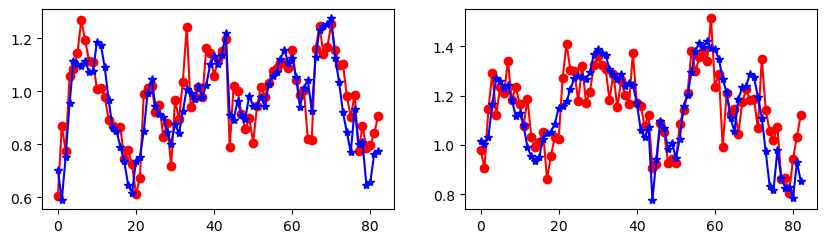

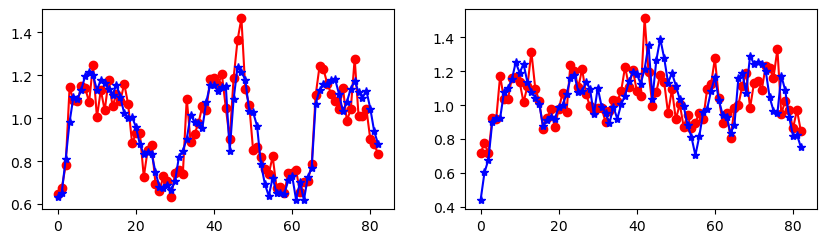

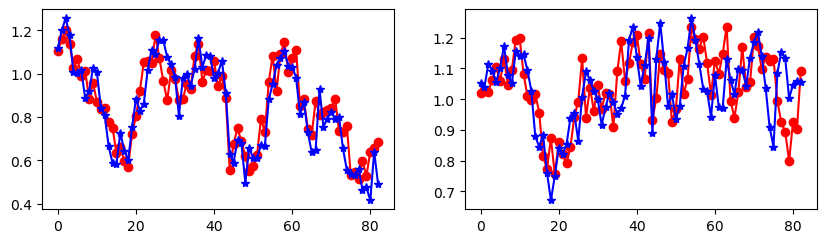

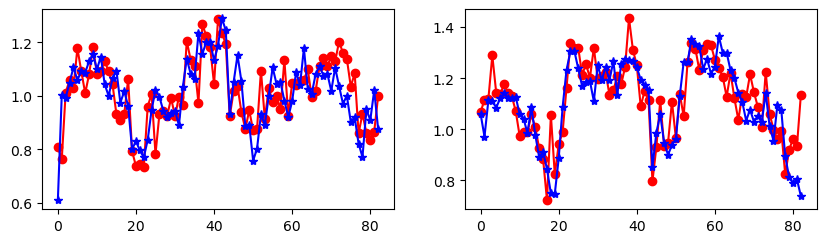

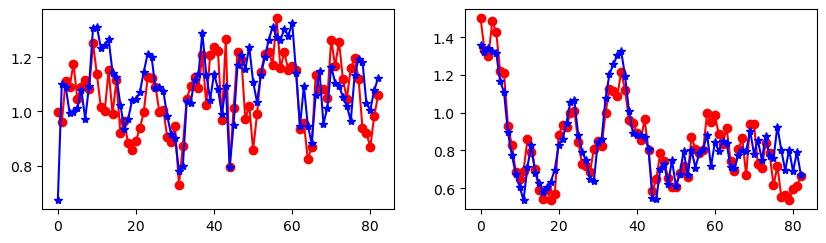

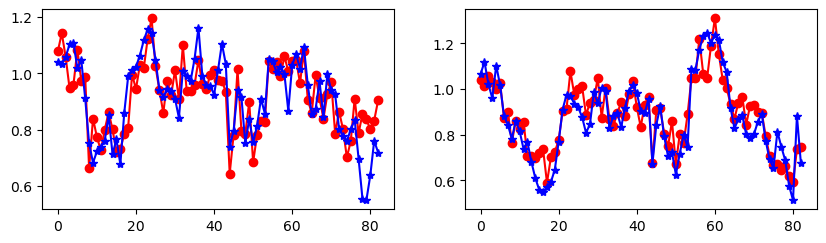

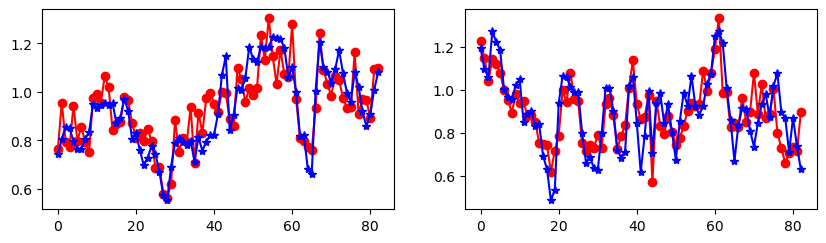

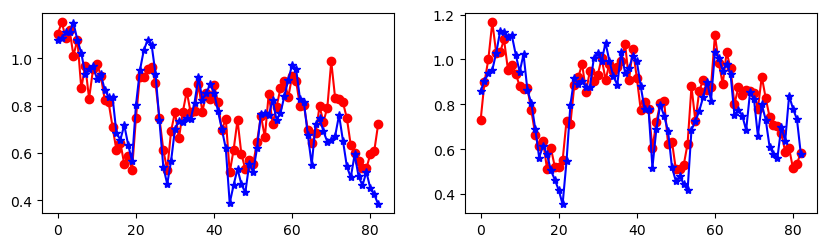

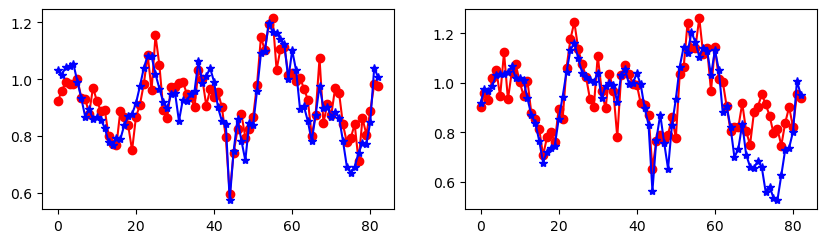

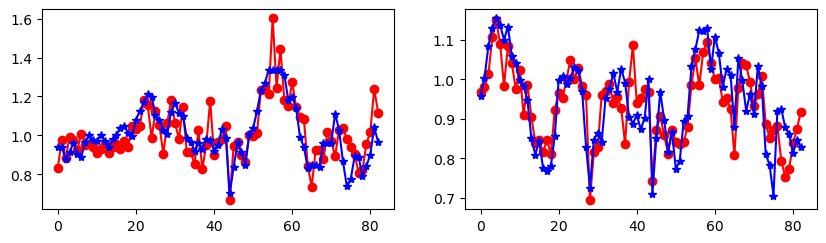

In [35]:
import matplotlib.pyplot as plt
#print(re_y_pre.T)
x= range(re_y_pre.shape[0])
for i in range(10):
    # 创建图形和子图
    fig, axs = plt.subplots(1, 2, figsize=(10, 2.6))  # 1行2列的子图布局

    axs[0].plot(x, re_y_pre[:,2*i],marker='o', linestyle='-', color='r')  # 使用红色线和圆形标记点
    axs[0].plot(x, re_y_real[:,2*i],marker='*', linestyle='-', color='b')  # 使用红色线和圆形标记点
    
    axs[1].plot(x, re_y_pre[:,2*i+1],marker='o', linestyle='-', color='r')  # 使用红色线和圆形标记点
    axs[1].plot(x, re_y_real[:,2*i+1],marker='*', linestyle='-', color='b')  # 使用红色线和圆形标记点
    
    #plt.plot(x, x_train[:,1,-1,1234].cpu().detach().numpy(),marker='o', linestyle='-', color='y')  # 使用红色线和圆形标记点
    plt.show()

In [46]:
dys.shape

torch.Size([83, 11, 90, 83])

In [62]:
#IG explanation
baseline = torch.zeros_like(nor_sta_fes)
#baseline[:,-1] = 0
#baseline[:,-2] = 0
#print(baseline[:5])
print(baseline.shape)

torch.Size([83, 11])


In [63]:
from captum.attr import IntegratedGradients
from functools import partial
ig = IntegratedGradients(partial(tcn, dys)) #dys,nor_sta_fes

staric_ig = np.zeros((83,83,11))
for j in range(83):
    mask = ig.attribute(nor_sta_fes.float(),baselines = baseline,target=j,internal_batch_size=83, n_steps=30).cpu().detach().numpy()
    staric_ig[j] = mask
    print(np.mean(abs(mask),axis = 0))

[0.00909327 0.01501046 0.00529045 0.01622533 0.00853549 0.00982556
 0.00859424 0.0141774  0.00633739 0.00943776 0.01237081]
[0.00629725 0.01297162 0.009764   0.01015348 0.01333019 0.00902633
 0.00650544 0.01213669 0.00813778 0.01197976 0.00887055]
[0.0067762  0.01702546 0.00728022 0.0125131  0.00546438 0.0078904
 0.00681907 0.01296196 0.0099091  0.00890569 0.0110654 ]
[0.00693365 0.0131616  0.00772409 0.01742273 0.01624599 0.01006513
 0.00676295 0.0092593  0.00490187 0.00754048 0.01367401]
[0.0091504  0.01855057 0.00481131 0.01817642 0.00685667 0.01030232
 0.00982543 0.01158581 0.00937055 0.01073289 0.01664759]
[0.01416006 0.01293023 0.00732638 0.01233899 0.00636103 0.01090427
 0.00700479 0.00876588 0.00580705 0.01037329 0.01208351]
[0.00965564 0.01301846 0.00662763 0.01379834 0.0065655  0.00834742
 0.00649137 0.00930412 0.00537457 0.00684693 0.01217327]
[0.00662981 0.01253012 0.00751318 0.01183977 0.00931034 0.00902998
 0.00732776 0.01018262 0.00927827 0.00714484 0.01014787]
[0.012235

In [54]:
from captum.attr import IntegratedGradients
from functools import partial
ig = IntegratedGradients(partial(tcn, nor_sta_fes)) #dys, nor_sta_fes

staric_ig = np.zeros((83,83,11,90,83))
for j in range(83):
    mask = ig.attribute(dys.float(),baselines = baseline,target=j,internal_batch_size=83, n_steps=10).cpu().detach().numpy()
    #staric_ig[j] = mask
    #print(np.mean(abs(mask),axis = 0))
    print(mask.shape)

[0.01006658 0.01556133 0.00581408 0.01564001 0.00703895 0.01017606
 0.00859316 0.01419282 0.00693079 0.01044903 0.01331289]


In [55]:
static_name = ['avg_eleva', 'std_eleva','medi_aspec','avg_planc', 'std_planc','avg_profc', 'std_profc','dis2river', 'dis2faults', 'avg_slope', 'std_slope']
len(static_name)

11

In [58]:
ys.shape

torch.Size([83, 83])

In [10]:
model_pth = './results/dy8_EWM_TCN_0.6202.pth'
tcn.load_state_dict(torch.load(model_pth))

outputs = tcn(x_test,nor_sta_fes).cpu().detach().numpy()
y_label1 = y_test.cpu().detach().numpy()
re_y_pre = (np.exp(2*outputs+1)-1).reshape((-1,1))
re_y_real = (np.exp(2*y_label1+1)-1).reshape((-1,1))
print(torch_corre(torch.tensor(re_y_pre),torch.tensor(re_y_real)))

tensor(0.6210)


In [67]:
import geopandas as gpd
ids_df = gpd.read_file('./data/lsu_data_47.shp')
#ids = ids_df['su_id']
ids_df['PCC'] = 0

In [68]:
    #outputs = tcn(x_test,nor_sta_fes).cpu().detach().numpy()
    y_label1 = y_test.cpu().detach().numpy()
    
    for i in range(89):
        re_y_pre = (np.exp(outputs[:,i]+1)-1)
        re_y_real = (np.exp(y_label1[:,i]+1)-1)
        PCC = torch_corre(torch.tensor(re_y_pre),torch.tensor(re_y_real)).numpy()
        ids_df['PCC'].iloc[i] = PCC
        #print(PCC)

/tmp/ipykernel_146/1211249067.py:8: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ids_df['PCC'].iloc[i] = PCC
/tmp/ipykernel_146/1211249067.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See

In [70]:
ids_df['PCC1'].mean()

0.5129479762386489

In [71]:
ids_df.to_file('./data/lsu_data_47.shp')

In [72]:
ids_df.to_csv('./data/lsu_data_47.csv',index=False)

tensor(0.6210)


ValueError: x and y must have same first dimension, but have shapes (13,) and (1157, 1)

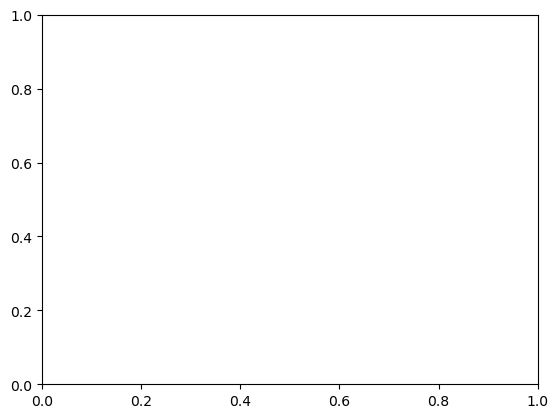

In [11]:
outputs = tcn(x_test,nor_sta_fes).cpu().detach().numpy()
y_label1 = y_test.cpu().detach().numpy()
re_y_pre = (np.exp(2*outputs+1)-1).reshape((-1,1))
re_y_real = (np.exp(2*y_label1+1)-1).reshape((-1,1))
print(torch_corre(torch.tensor(re_y_pre),torch.tensor(re_y_real)))
    
x = range(y_label1.shape[0])
import matplotlib.pyplot as plt
plt.plot(x, re_y_pre,marker='o', linestyle='-', color='r')  # 使用红色线和圆形标记点
plt.plot(x, re_y_real,marker='*', linestyle='-', color='b')  # 使用红色线和圆形标记点
#plt.plot(x, x_train[:,1,-1,1234].cpu().detach().numpy(),marker='o', linestyle='-', color='y')  # 使用红色线和圆形标记点
plt.show()

In [31]:
# test for 1 node, su_id = 1234
from torch.nn.utils import weight_norm
import torch
import torch.nn as nn
import torch.nn.functional as F
class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        """
        裁剪的模块，裁剪多出来的padding
        """
        return x[:, :, :-self.chomp_size].contiguous()


class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        """
        相当于一个Residual block

        :param n_inputs: int, 输入通道数
        :param n_outputs: int, 输出通道数
        :param kernel_size: int, 卷积核尺寸
        :param stride: int, 步长，一般为1
        :param dilation: int, 膨胀系数
        :param padding: int, 填充系数
        :param dropout: float, dropout比率
        """
        super(TemporalBlock, self).__init__()
        self.conv1 = weight_norm(nn.Conv1d(n_inputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        # 经过conv1，输出的size其实是(Batch, input_channel, seq_len + padding)
        self.chomp1 = Chomp1d(padding)  # 裁剪掉多出来的padding部分，维持输出时间步为seq_len
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = weight_norm(nn.Conv1d(n_outputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp2 = Chomp1d(padding)  # 裁剪掉多出来的padding部分，维持输出时间步为seq_len
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1)
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        """
        参数初始化

        :return:
        """
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        """
        :param x: size of (Batch, input_channel, seq_len)
        :return:
        """
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)
        #return out


class TCN(nn.Module):
    def __init__(self, num_inputs, channels, kernel_size=2, dropout=0.2):
        """
        :param num_inputs: int， 输入通道数
        :param channels: list，每层的hidden_channel数，例如[25,25,25,25]表示有4个隐层，每层hidden_channel数为25
        :param kernel_size: int, 卷积核尺寸
        :param dropout: float, drop_out比率
        """
        super(TCN, self).__init__()
        super().__init__()
        layers = []
        num_levels = len(channels)
        for i in range(num_levels):
            dilation_size = 2 ** i  # 膨胀系数：1，2，4，8……
            in_channels = num_inputs if i == 0 else channels[i - 1]  # 确定每一层的输入通道数
            out_channels = channels[i]  # 确定每一层的输出通道数
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size - 1) * dilation_size, dropout=dropout)]

        self.network = nn.Sequential(*layers)
        sh1 = 64
        self.fc1 = nn.Linear(11, sh1)
        self.drop1 = nn.Dropout(0.5)
        self.out = nn.Linear(channels[-1]+sh1, 1)
        self.relu = nn.ReLU()  # 激活函数

    def forward(self, x1,x2):
        """
        :param x: size of (Batch, input_channel, seq_len)
        :return: size of (Batch, output_channel, seq_len)
        """
        x1 = self.network(x1)
        x1 = x1[:, :, -1]
        #x1 = self.fc1(x1)
        #print(x1.shape)
        
        x2 = x2.view((1,11))
        x2 = x2.repeat(x1.shape[0], 1)
        #print(x2.shape)
        x2 = self.relu(self.fc1(x2))
        x2 = self.drop1(x2)
        #print(x2.shape)
        out = torch.cat((x1, x2), dim=1)
        #print(out.shape)
        # Output layer
        out = self.out(out)
        return out




# Example usage:
num_inputs = 8  # Number of input features
num_channels = [32, 32, 64]  # Number of channels in each layer
kernel_size = 5  # Kernel size for the convolutional layers
dropout = 0.5  # Dropout probability
device = (
    torch.device("cuda")
    if torch.cuda.is_available()
    else torch.device("cpu")
)

 train loss: 0.46641453419412887 validation loss: -0.2474617213010788
 train loss: 0.014488243311643601 validation loss: -0.3778400421142578
 train loss: 0.010731640830636024 validation loss: 0.3526841998100281
 train loss: 0.006831261675272669 validation loss: 0.10930682718753815
 train loss: 0.004960262715550405 validation loss: -0.18596327304840088
 train loss: 0.004508021886327437 validation loss: 0.2875448167324066
 train loss: 0.0029483787915004153 validation loss: -0.32223430275917053
 train loss: 0.0026886853322918925 validation loss: -0.13605014979839325
44 :  -0.25415945053100586 [-0.25415945053100586]
tensor(-0.1980)
[[11.0377245 13.119746  18.168158  12.461894  11.022027  11.41563
  10.49164   11.1219    11.020599  11.157702  14.490822  12.470383
  11.653455 ]]


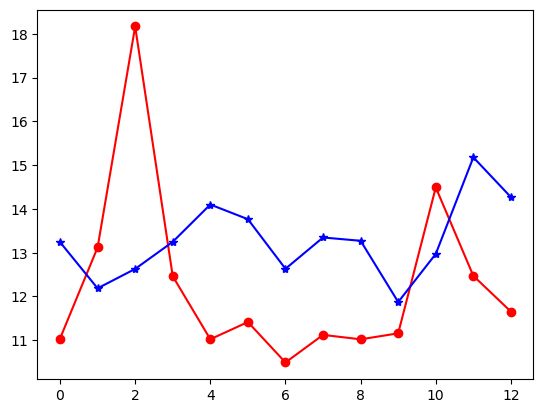

 train loss: 0.6980970012290137 validation loss: -0.6688177585601807
 train loss: 0.030701533013156482 validation loss: 0.766964852809906
 train loss: 0.021076367263283047 validation loss: -0.0216651763767004
 train loss: 0.01281464219625507 validation loss: 0.17344050109386444
 train loss: 0.010530086101165839 validation loss: -0.11639904975891113
 train loss: 0.008106565262590135 validation loss: -0.2659822702407837
 train loss: 0.00872658569631832 validation loss: -0.19288034737110138
 train loss: 0.007577477222574609 validation loss: -0.4292244017124176
44 :  0.083825021982193 [-0.25415945053100586, 0.42180949449539185]
tensor(0.1041)
[[ 9.518372 15.044676 12.552204  8.042701 11.314327  9.377534 11.361556
  12.97547  10.641789 10.875336 12.950003 14.888464 12.33322 ]]


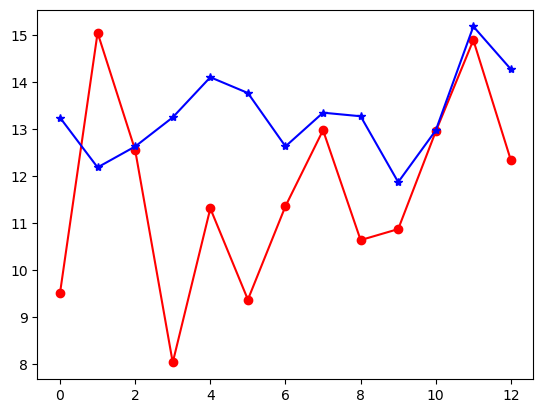

 train loss: 1.1510346974645342 validation loss: -0.49601754546165466
 train loss: 0.03464948939425605 validation loss: 0.07230515033006668
 train loss: 0.016304774076810906 validation loss: 0.2815535068511963
 train loss: 0.010032604475106512 validation loss: -0.6128400564193726
 train loss: 0.014296630237783705 validation loss: 0.11728683859109879
 train loss: 0.007129602134227753 validation loss: 0.10293937474489212
 train loss: 0.007930180656590633 validation loss: -0.22955366969108582
 train loss: 0.008466145742152419 validation loss: -0.3304766118526459
44 :  0.032655030488967896 [-0.25415945053100586, 0.42180949449539185, -0.0696849524974823]
tensor(-0.3972)
[[12.356863 13.248858 14.110176  8.510538  8.466794 10.589516 12.994502
   9.327537 10.814946 10.960665 11.517855 11.907292  9.900949]]


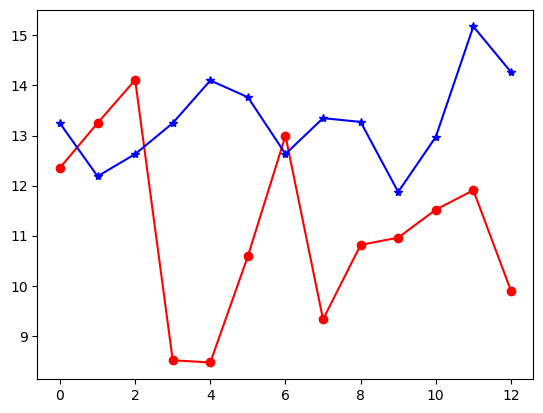

 train loss: 0.9903467008045741 validation loss: 0.6543886661529541
 train loss: 0.01596292688378266 validation loss: -0.13835299015045166
 train loss: 0.00795167861506343 validation loss: 0.10721474140882492
 train loss: 0.007323024860982384 validation loss: -0.16910968720912933
 train loss: 0.005442616183842931 validation loss: -0.1851091980934143
 train loss: 0.004967488371767104 validation loss: 0.0746314525604248
 train loss: 0.00376070196341191 validation loss: -0.13359370827674866
 train loss: 0.004220472874918155 validation loss: -0.011143178679049015
44 :  -0.008903462439775467 [-0.25415945053100586, 0.42180949449539185, -0.0696849524974823, -0.13357894122600555]
tensor(0.4425)
[[11.211903 11.088421 12.759261 12.594442 10.59715  11.384017 11.404694
  11.166744 10.809339 10.268782 11.863484 13.011724 12.26346 ]]


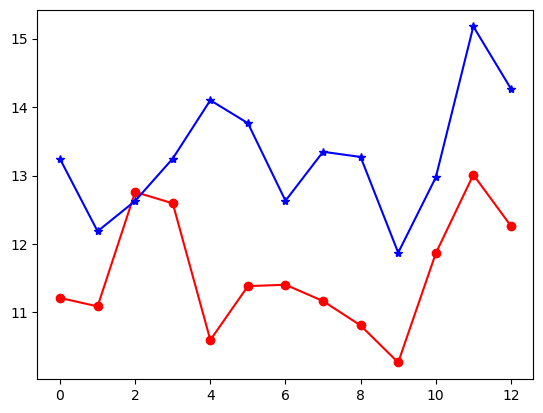

 train loss: 0.42619853360312326 validation loss: -0.061886414885520935
 train loss: 0.024383005180529185 validation loss: 0.18168357014656067
 train loss: 0.010131204873323441 validation loss: -0.4950760304927826
 train loss: 0.007236681213336331 validation loss: -0.37019816040992737
 train loss: 0.004367827198335103 validation loss: 0.11165997385978699
 train loss: 0.004258716745035989 validation loss: 0.046926628798246384
 train loss: 0.004721997724846006 validation loss: 0.14521661400794983
 train loss: 0.0033052051107266118 validation loss: 0.487697571516037
44 :  0.06331502497196198 [-0.25415945053100586, 0.42180949449539185, -0.0696849524974823, -0.13357894122600555, 0.35218897461891174]
tensor(0.3167)
[[13.134204  10.890043  10.738694  13.11291   11.329212   8.967656
  11.069213  10.822652  11.7254925  9.583537  11.963022  12.334714
  11.548062 ]]


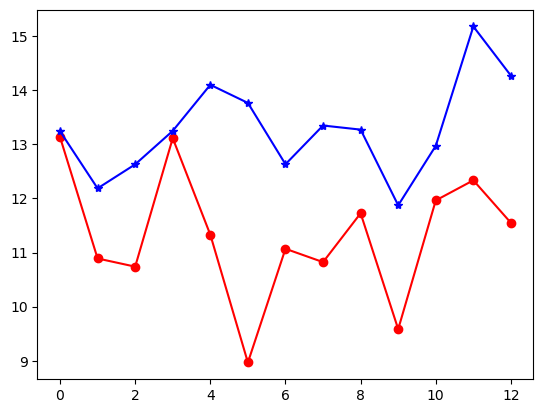

 train loss: 1.2589253834315708 validation loss: 0.1586652398109436
 train loss: 0.03609565060053553 validation loss: 0.21678002178668976


KeyboardInterrupt: 

In [39]:
ex_list = [330,48,21736,18900,11814,22401]
device = torch.device("cuda:1")
nor_sta_fes = nor_sta_fes.to(device)
x_train = x_train.to(device)
x_test = x_test.to(device)


for ex_id in range(44,45):

    #batch_size = 10
    train_data = torch.utils.data.TensorDataset(x_train[:,:,:,ex_id], y_train[:,ex_id])
    train_iter = torch.utils.data.DataLoader(train_data, batch_size, shuffle=True)
    val_data = torch.utils.data.TensorDataset(x_test[:,:,:,ex_id], y_test[:,ex_id])
    val_iter = torch.utils.data.DataLoader(val_data, batch_size)
    #test_data = torch.utils.data.TensorDataset(x_test_d[:,:,:,ex_id], y_test_d[:,ex_id])
    #test_iter = torch.utils.data.DataLoader(test_data, batch_size)
    vals = []
    for cc in range(10):
        for j in range(1):
            tcn = TCN(num_inputs, num_channels, kernel_size, dropout).to(device)
            #print(tcn)
            criterion = nn.MSELoss()  # 均方误差损失函数
            optimizer = torch.optim.Adam(tcn.parameters(), lr=0.002,weight_decay = 5e-5)  # Adam优化器
            scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.85)

            #loss = nn.MSELoss()
            loss = WMSE_loss()
            min_val_loss = np.inf
            for epoch in range(1, 300+1):
                l_sum, n = 0.0, 0
                tcn.train()
                for x, y in train_iter:
                    x,y = x.to(device),y.to(device)
                    y_pred = tcn(x,nor_sta_fes[ex_id,:]).view(-1,)
                    #print(y_pred.shape,y.shape)
                    l = loss(y_pred, y)
                    optimizer.zero_grad()
                    l.backward()
                    optimizer.step()
                    l_sum += l.item() * y.shape[0]
                    n += y.shape[0]
                scheduler.step()
                val_pre = tcn(x_test[:,:,:,ex_id],nor_sta_fes[ex_id,:]).view(-1,).cpu()
                #train_loss = 
                #val_loss = torch_corre(val_pre,y_val[:,ex_id])
                #print(val_pre.shape,y_val[:,ex_id].shape)
                val_loss = torch_corre(val_pre,y_test[:,ex_id])
                if epoch%40 ==1:
                    print(" train loss:",l_sum / n,"validation loss:",val_loss.item())

            vals.append(val_loss.item())
        print(ex_id,': ', np.mean(vals),vals)
        outputs = tcn(x_test[:,:,:,ex_id],nor_sta_fes[ex_id,:]).cpu().detach().numpy()
        y_label1 = y_test[:,ex_id].cpu().detach().numpy()
        re_y_pre = (np.exp(2*outputs)-1).reshape((-1,1))
        re_y_real = (np.exp(2*y_label1)-1).reshape((-1,1))
        print(torch_corre(torch.tensor(re_y_pre),torch.tensor(re_y_real)))

        x = range(y_label1.shape[0])
        import matplotlib.pyplot as plt
        print(re_y_pre.T)
        plt.plot(x, re_y_pre,marker='o', linestyle='-', color='r')  # 使用红色线和圆形标记点
        plt.plot(x, re_y_real,marker='*', linestyle='-', color='b')  # 使用红色线和圆形标记点
        #plt.plot(x, x_train[:,1,-1,1234].cpu().detach().numpy(),marker='o', linestyle='-', color='y')  # 使用红色线和圆形标记点
        plt.show()

 train loss: 0.2761169497455869 validation loss: 0.3756408393383026
 train loss: 0.1003595586333956 validation loss: 0.6680284142494202
 train loss: 0.08162340223789215 validation loss: 0.5434529781341553
 train loss: 0.06543909385800362 validation loss: 0.7104128003120422
 train loss: 0.04568143944655146 validation loss: 0.762363851070404
 train loss: 0.348188305752618 validation loss: 0.33747413754463196
 train loss: 0.11585612233195985 validation loss: 0.5193521976470947
 train loss: 0.09064350106886455 validation loss: 0.6837998032569885
 train loss: 0.07038162861551557 validation loss: 0.6467657685279846
 train loss: 0.04739515323724065 validation loss: 0.6413182616233826
0 :  0.5631103664636612 [0.6287745833396912, 0.4974461495876312]
tensor(0.7850)


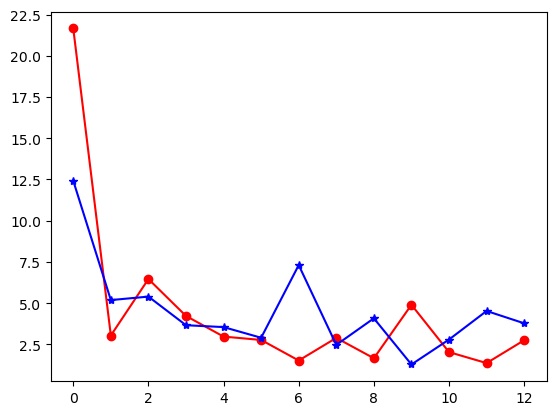

 train loss: 0.6306284521307264 validation loss: 0.2138972133398056
 train loss: 0.15542175663369043 validation loss: 0.6936956644058228
 train loss: 0.10454090024743762 validation loss: 0.4742443859577179
 train loss: 0.10960105508565902 validation loss: 0.5938743352890015
 train loss: 0.08357965531093733 validation loss: 0.5152426958084106
 train loss: 0.7655365296772548 validation loss: -0.14328685402870178
 train loss: 0.16626264580658504 validation loss: 0.4875528812408447
 train loss: 0.12634736384664264 validation loss: 0.48196741938591003
 train loss: 0.12281566730567388 validation loss: 0.5072686672210693
 train loss: 0.10573508590459824 validation loss: 0.6252971887588501
1 :  0.4600478559732437 [0.6543015241622925, 0.26579418778419495]
tensor(0.3022)


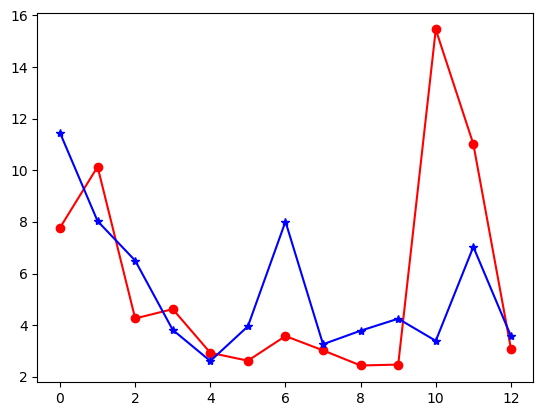

 train loss: 0.6873443441731589 validation loss: -0.36898910999298096
 train loss: 0.15194260605743953 validation loss: 0.4890069365501404
 train loss: 0.11298895946570806 validation loss: 0.3093234598636627
 train loss: 0.10149886714560645 validation loss: 0.33756589889526367
 train loss: 0.0708106945667948 validation loss: 0.23630593717098236
 train loss: 1.703393999167851 validation loss: 0.19731993973255157
 train loss: 0.15551384261676243 validation loss: 0.40134119987487793
 train loss: 0.11283831191914422 validation loss: 0.349164217710495
 train loss: 0.11210263669490814 validation loss: 0.6279754638671875
 train loss: 0.09458052175385612 validation loss: 0.6623092293739319
2 :  0.32065822184085846 [0.29582005739212036, 0.34549638628959656]
tensor(0.2373)


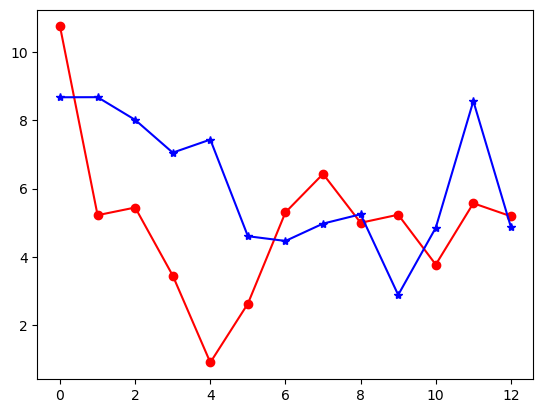

 train loss: 0.4622682988643646 validation loss: -0.14625026285648346
 train loss: 0.13629913117204392 validation loss: 0.14301010966300964
 train loss: 0.09694222786596843 validation loss: 0.5541926026344299
 train loss: 0.10055519118905068 validation loss: 0.2202671468257904
 train loss: 0.06720893627830914 validation loss: 0.3620411157608032
 train loss: 0.22942805417946407 validation loss: 0.4255344271659851
 train loss: 0.13104014609541212 validation loss: 0.2845989763736725
 train loss: 0.08198260106146335 validation loss: -0.23804187774658203
 train loss: 0.06032396948763302 validation loss: -0.050452642142772675
 train loss: 0.04852317906916141 validation loss: -0.09597287327051163
3 :  -0.1965136919170618 [0.010204773396253586, -0.4032321572303772]
tensor(-0.2643)


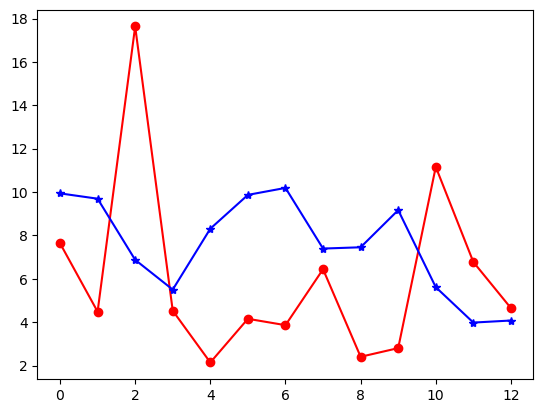

 train loss: 0.7760206401348114 validation loss: -0.3792729079723358
 train loss: 0.1557153576186725 validation loss: 0.6186498403549194
 train loss: 0.10865011023623602 validation loss: 0.715021550655365
 train loss: 0.08002504642520632 validation loss: 0.5569602251052856
 train loss: 0.07346180251666477 validation loss: 0.4715544879436493
 train loss: 0.4114010844911848 validation loss: -0.3595750629901886
 train loss: 0.1378704160451889 validation loss: 0.42407432198524475
 train loss: 0.09905151150056295 validation loss: 0.5802513957023621
 train loss: 0.06310200010027205 validation loss: 0.4618299603462219
 train loss: 0.04447429424950055 validation loss: 0.38916096091270447
4 :  0.3107813596725464 [0.44608891010284424, 0.17547380924224854]
tensor(0.3264)


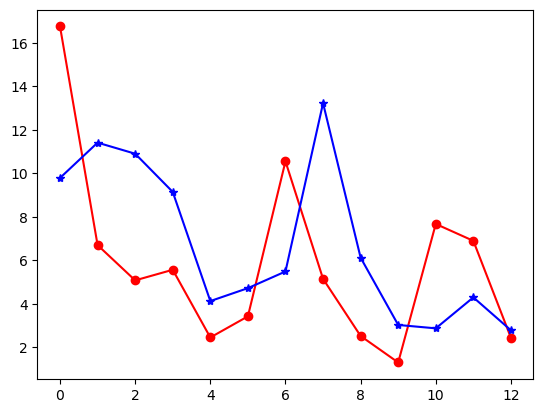

 train loss: 0.3840264801468168 validation loss: 0.01741117797791958
 train loss: 0.13810378249202457 validation loss: 0.12461839616298676
 train loss: 0.09562735248889243 validation loss: 0.5331679582595825
 train loss: 0.10318577779190881 validation loss: 0.33565717935562134
 train loss: 0.07785855148519788 validation loss: 0.25402531027793884
 train loss: 0.5006429084709713 validation loss: -0.1714833378791809
 train loss: 0.1447330823966435 validation loss: -0.12533579766750336
 train loss: 0.09226819510970796 validation loss: 0.22379033267498016
 train loss: 0.07437587178179196 validation loss: 0.026622474193572998
 train loss: 0.060870209602372986 validation loss: 0.30044591426849365
5 :  0.24420341104269028 [0.12128050625324249, 0.36712631583213806]
tensor(0.0461)


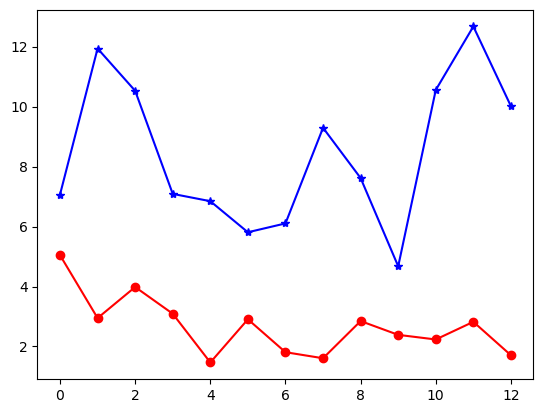

 train loss: 0.41478231634412494 validation loss: 0.23129606246948242
 train loss: 0.11409252690417426 validation loss: -0.41338086128234863
 train loss: 0.0699324912258557 validation loss: 0.15332692861557007
 train loss: 0.05813681366188186 validation loss: 0.44339585304260254
 train loss: 0.04643239937722683 validation loss: 0.30523520708084106
 train loss: 0.6374074339866638 validation loss: -0.15068477392196655
 train loss: 0.11968903041311672 validation loss: 0.12949438393115997
 train loss: 0.0798648333975247 validation loss: 0.4447310268878937
 train loss: 0.05925958412034171 validation loss: 0.11114685982465744
 train loss: 0.0622559985944203 validation loss: 0.2378934621810913
6 :  0.38215968012809753 [0.41864511370658875, 0.3456742465496063]
tensor(0.3735)


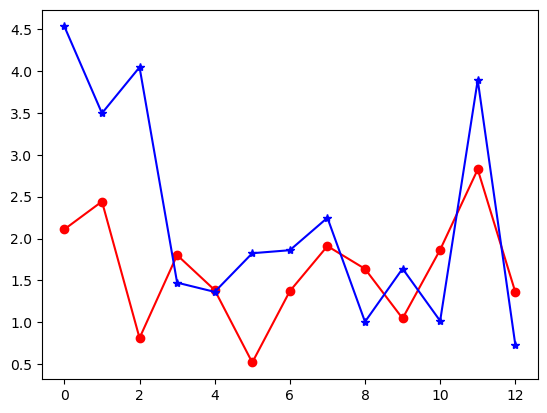

 train loss: 0.5053655820233481 validation loss: -0.3845728635787964
 train loss: 0.13912184834480285 validation loss: 0.28195858001708984
 train loss: 0.09560749232769013 validation loss: 0.2752933204174042
 train loss: 0.09243951461144856 validation loss: 0.45465973019599915
 train loss: 0.07474612316914968 validation loss: 0.4764920771121979
 train loss: 0.41577174152646745 validation loss: -0.02141793817281723
 train loss: 0.12273025512695312 validation loss: 0.5072458386421204
 train loss: 0.0812912004334586 validation loss: 0.49573612213134766
 train loss: 0.08805176935025624 validation loss: 0.4502003788948059
 train loss: 0.06183195997561727 validation loss: 0.46375593543052673
7 :  0.5654173493385315 [0.5371232032775879, 0.5937114953994751]
tensor(0.4054)


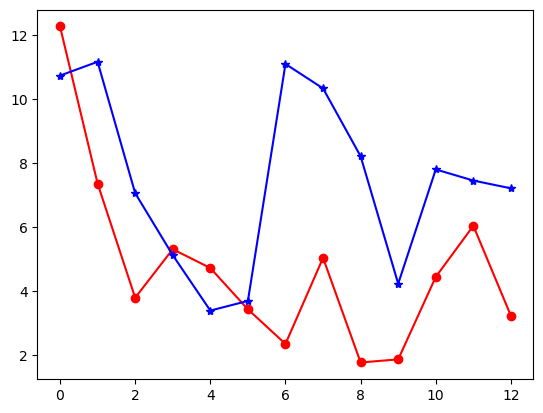

 train loss: 0.5926679491996765 validation loss: 0.3447352945804596
 train loss: 0.11662704071828298 validation loss: 0.5125162601470947
 train loss: 0.09466803861515863 validation loss: 0.5028309226036072
 train loss: 0.08457594322306769 validation loss: 0.3864404857158661
 train loss: 0.08749738548483167 validation loss: 0.18598604202270508
 train loss: 0.40448807903698514 validation loss: -0.15697765350341797
 train loss: 0.11173092637743269 validation loss: -0.18775326013565063
 train loss: 0.10247202749763216 validation loss: 0.3650718629360199
 train loss: 0.086653697597129 validation loss: 0.4735454320907593
 train loss: 0.0699151849108083 validation loss: 0.30223944783210754
8 :  0.18170109670609236 [0.3533812463283539, 0.010020947083830833]
tensor(0.4749)


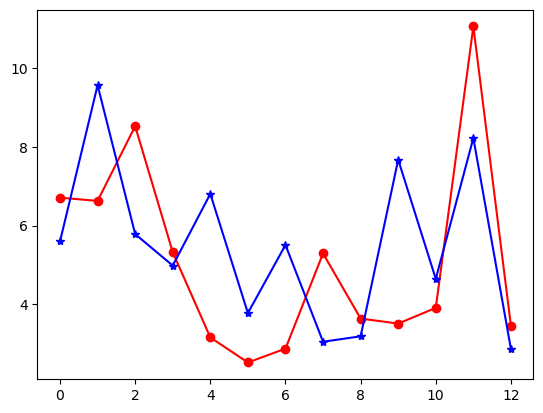

 train loss: 1.2349849879741668 validation loss: 0.24886928498744965
 train loss: 0.1381866421018328 validation loss: -0.027036938816308975
 train loss: 0.13905339411326817 validation loss: 0.08078593015670776
 train loss: 0.10556344592145511 validation loss: -0.006958494428545237
 train loss: 0.07832770092146737 validation loss: 0.28628864884376526
 train loss: 1.1898815397705351 validation loss: 0.1985565423965454
 train loss: 0.1509339690208435 validation loss: 0.5429631471633911
 train loss: 0.14202084477458682 validation loss: 0.4698265492916107
 train loss: 0.10790686288050243 validation loss: -0.08903787285089493
 train loss: 0.08125337745462145 validation loss: -0.11835531145334244
9 :  0.02755790948867798 [0.17496423423290253, -0.11984841525554657]
tensor(-0.1617)


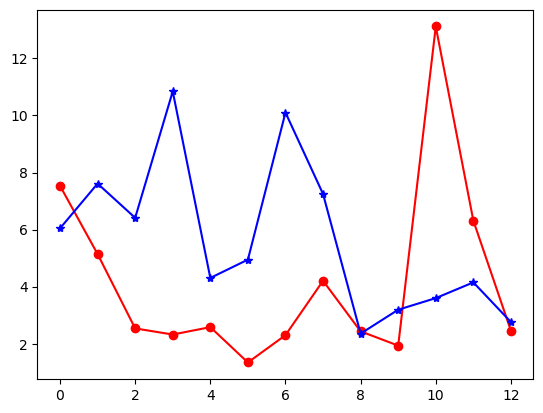

 train loss: 0.5463975421019963 validation loss: -0.4963001012802124
 train loss: 0.15674506085259574 validation loss: -0.028015300631523132
 train loss: 0.14094127927507674 validation loss: 0.17040494084358215
 train loss: 0.11643774211406707 validation loss: 0.2657247483730316
 train loss: 0.08227760280881609 validation loss: 0.6993153095245361
 train loss: 0.5695381990500858 validation loss: 0.5391682982444763
 train loss: 0.14915306504283632 validation loss: 0.059907473623752594
 train loss: 0.13848557344504764 validation loss: 0.113444484770298
 train loss: 0.10063924704279219 validation loss: -0.061793599277734756
 train loss: 0.09337122078452792 validation loss: 0.21038274466991425
10 :  0.41297656297683716 [0.4097656309604645, 0.41618749499320984]
tensor(0.1991)


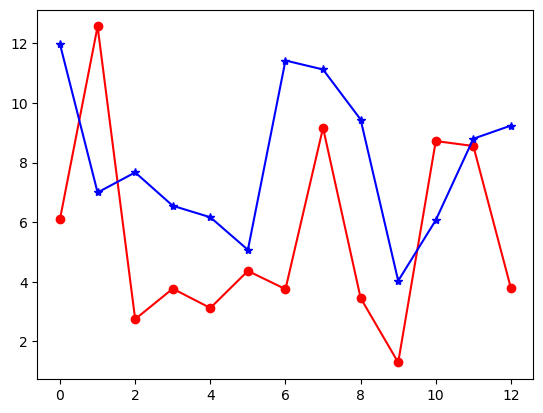

 train loss: 0.3401593510593687 validation loss: -0.0017547606257721782
 train loss: 0.08569325570549284 validation loss: 0.011813315562903881
 train loss: 0.06439469062856265 validation loss: 0.36805376410484314
 train loss: 0.050373744325978416 validation loss: -0.11160789430141449
 train loss: 0.04063792595905917 validation loss: 0.09592100232839584
 train loss: 0.40430732795170377 validation loss: -0.35581016540527344
 train loss: 0.09393958087478366 validation loss: 0.009648298844695091
 train loss: 0.06482064787830626 validation loss: 0.3681771457195282
 train loss: 0.056512898206710814 validation loss: 0.04481795057654381
 train loss: 0.04425112221922193 validation loss: 0.29659438133239746
11 :  -0.04310494847595692 [-0.11972328275442123, 0.0335133858025074]
tensor(0.3621)


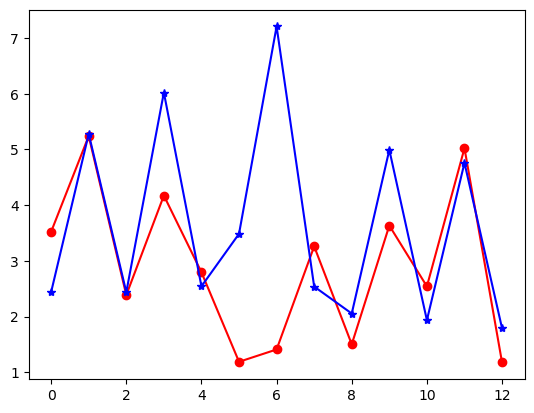

 train loss: 0.36001740055424825 validation loss: 0.1267872452735901
 train loss: 0.12068085883344923 validation loss: 0.015166976489126682
 train loss: 0.09910444361822945 validation loss: 0.38481244444847107
 train loss: 0.07738491701228278 validation loss: 0.23437173664569855
 train loss: 0.06370240088020052 validation loss: 0.3674152195453644
 train loss: 0.4650418707302639 validation loss: 0.09376421570777893
 train loss: 0.10021963236587388 validation loss: -0.09407050907611847
 train loss: 0.09321671234709876 validation loss: 0.4646500051021576
 train loss: 0.06749477929302625 validation loss: 0.4294680655002594
 train loss: 0.06343956270388194 validation loss: 0.6023533344268799
12 :  0.4089201092720032 [0.2199411392211914, 0.5978990793228149]
tensor(0.6646)


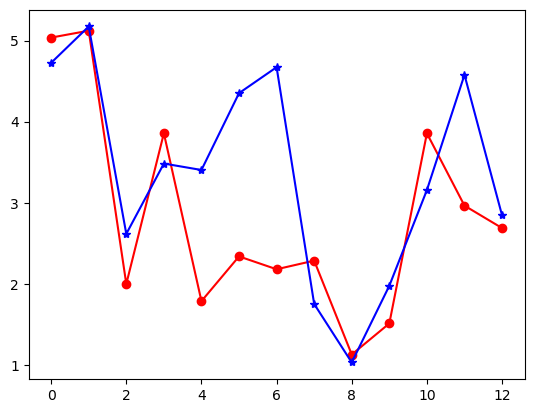

 train loss: 0.354707350901195 validation loss: 0.3587290942668915
 train loss: 0.1175662106701306 validation loss: -0.19727224111557007
 train loss: 0.08968573968325343 validation loss: -0.28574830293655396
 train loss: 0.05656614936888218 validation loss: 0.03606313094496727
 train loss: 0.06015655930553164 validation loss: -0.3645961284637451
 train loss: 0.39440596188817706 validation loss: -0.0565517358481884
 train loss: 0.12983558135373252 validation loss: 0.11000364273786545
 train loss: 0.10889791888850076 validation loss: 0.05257919430732727
 train loss: 0.0639217799263341 validation loss: -0.3599202036857605
 train loss: 0.06303661710449628 validation loss: -0.3804931342601776
13 :  -0.18589463829994202 [-0.1624922752380371, -0.20929700136184692]
tensor(-0.3251)


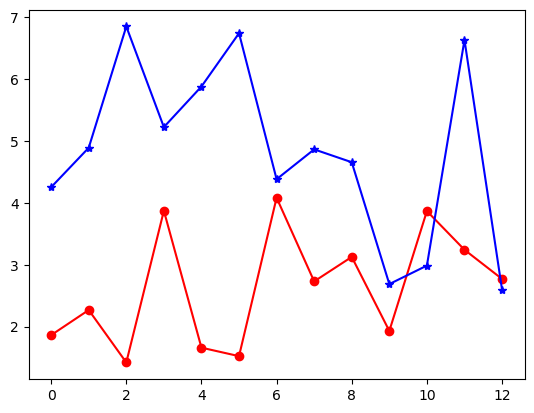

 train loss: 0.4318868500845773 validation loss: -0.14135664701461792
 train loss: 0.06997408568859101 validation loss: -0.21437209844589233
 train loss: 0.06337776790772165 validation loss: 0.02725183218717575
 train loss: 0.04935941387500082 validation loss: -0.07430865615606308
 train loss: 0.03706171406166894 validation loss: 0.3406657576560974
 train loss: 0.22821425412382398 validation loss: 0.5036301612854004
 train loss: 0.0804410593850272 validation loss: 0.05352640151977539
 train loss: 0.06862075036125524 validation loss: 0.4121468961238861
 train loss: 0.038669685167925696 validation loss: 0.43421614170074463
 train loss: 0.03634013975305217 validation loss: 0.37467801570892334
14 :  0.011700309813022614 [-0.08854029327630997, 0.1119409129023552]
tensor(0.4753)


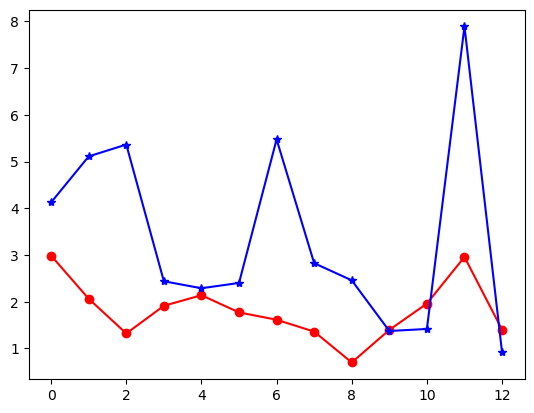

 train loss: 0.3479077926703862 validation loss: 0.19972270727157593
 train loss: 0.1333734365446227 validation loss: -0.17575232684612274
 train loss: 0.09590382384402411 validation loss: -0.07806238532066345
 train loss: 0.09175207551036563 validation loss: -0.3955378234386444
 train loss: 0.07612680249980518 validation loss: -0.5925111770629883
 train loss: 0.19158971863133567 validation loss: 0.0717129036784172
 train loss: 0.09467061630317143 validation loss: -0.14909033477306366
 train loss: 0.09254275730678013 validation loss: -0.10266497731208801
 train loss: 0.06574431572641645 validation loss: 0.10580252856016159
 train loss: 0.05351357364228793 validation loss: -0.20241834223270416
15 :  -0.05621757113840431 [-0.11621764302253723, 0.003782500745728612]
tensor(-0.2444)


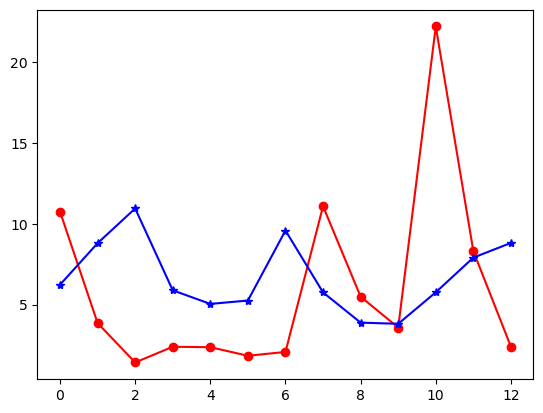

 train loss: 0.46948170789650506 validation loss: 0.15427710115909576
 train loss: 0.1647178019796099 validation loss: -0.1488618403673172
 train loss: 0.08166091803993497 validation loss: -0.06429645419120789
 train loss: 0.08252426322017398 validation loss: -0.33883723616600037
 train loss: 0.0613083649958883 validation loss: 0.12063547223806381
 train loss: 0.5804168275424413 validation loss: 0.027406802400946617
 train loss: 0.1256273137671607 validation loss: 0.2091100662946701
 train loss: 0.06825733110308647 validation loss: -0.12790673971176147
 train loss: 0.07045034712978772 validation loss: -0.10190004110336304
 train loss: 0.05297515679683004 validation loss: 0.054882295429706573
16 :  -0.035129282623529434 [-0.18319299817085266, 0.11293443292379379]
tensor(-0.3432)


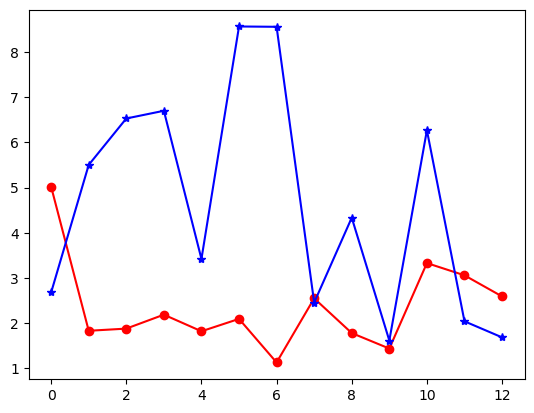

 train loss: 0.2477038155708994 validation loss: 0.5756405591964722
 train loss: 0.08787857528243746 validation loss: 0.13131079077720642
 train loss: 0.0457410892205579 validation loss: -0.1473369002342224
 train loss: 0.03721471950411796 validation loss: 0.122020423412323
 train loss: 0.025945134407707623 validation loss: 0.08874895423650742
 train loss: 0.4710731221096856 validation loss: 0.1693112552165985
 train loss: 0.08028340563178063 validation loss: 0.38681408762931824
 train loss: 0.06585561100925719 validation loss: -0.5639740228652954
 train loss: 0.05101371253175395 validation loss: -0.08852580189704895
 train loss: 0.042516444836344036 validation loss: -0.2858686149120331
17 :  -0.1684272214770317 [-0.13157090544700623, -0.2052835375070572]
tensor(-0.2254)


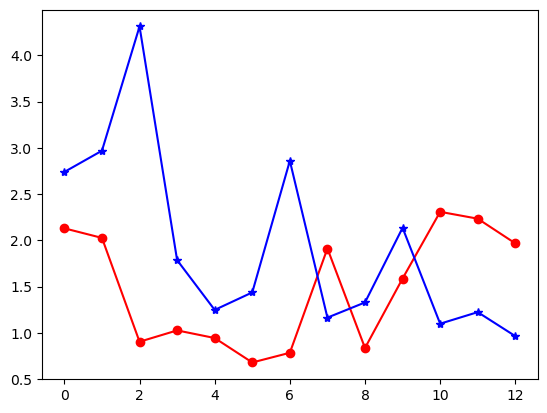

 train loss: 0.18839597616876874 validation loss: 0.3160369098186493
 train loss: 0.06330005579761096 validation loss: 0.08718264847993851
 train loss: 0.06368164132748332 validation loss: -0.004738954361528158
 train loss: 0.03665769829281739 validation loss: 0.06865634024143219
 train loss: 0.03241089465362685 validation loss: -0.11332366615533829
 train loss: 0.3079044840165547 validation loss: 0.5936204195022583
 train loss: 0.08351180297987802 validation loss: 0.13885779678821564
 train loss: 0.06175856930868966 validation loss: -0.036428965628147125
 train loss: 0.04422839858702251 validation loss: -0.10642880201339722
 train loss: 0.03431061320006847 validation loss: 0.12649482488632202
18 :  -0.10628054570406675 [-0.19205348193645477, -0.020507609471678734]
tensor(-0.4957)


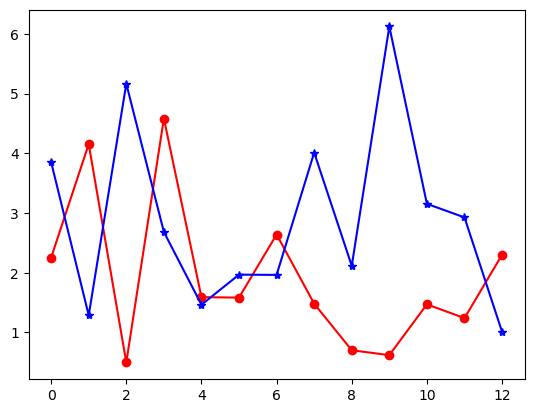

 train loss: 0.5034020032201495 validation loss: 0.19005700945854187
 train loss: 0.11154322980770043 validation loss: 0.24224433302879333
 train loss: 0.09323626969541822 validation loss: 0.6484849452972412
 train loss: 0.07089856511780195 validation loss: 0.7824418544769287
 train loss: 0.060461936092802454 validation loss: 0.5542708039283752
 train loss: 0.3002728900739125 validation loss: 0.21515679359436035
 train loss: 0.11285493969917297 validation loss: 0.6172224879264832
 train loss: 0.1013690465262958 validation loss: 0.6680124998092651
 train loss: 0.07142733122621264 validation loss: 0.6046920418739319
 train loss: 0.044755699272666656 validation loss: 0.7266179323196411
19 :  0.7033429145812988 [0.6922101378440857, 0.714475691318512]
tensor(0.6416)


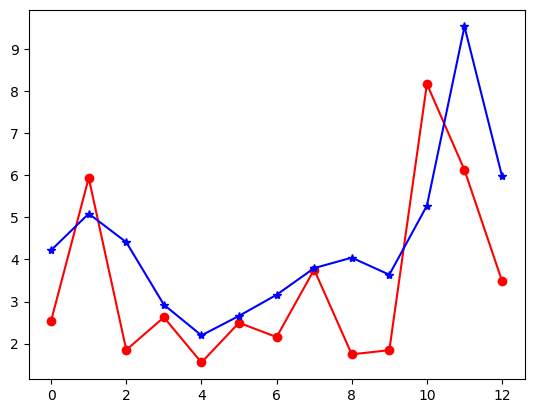

 train loss: 0.3046009459665843 validation loss: 0.38852885365486145
 train loss: 0.09864829959613937 validation loss: 0.32550930976867676
 train loss: 0.08279334434441157 validation loss: 0.3735532760620117
 train loss: 0.07429054294313703 validation loss: -0.18866078555583954
 train loss: 0.05599061037812914 validation loss: 0.35953426361083984
 train loss: 0.548506508554731 validation loss: 0.21034353971481323
 train loss: 0.12914574401719228 validation loss: 0.45728713274002075
 train loss: 0.0836244700210435 validation loss: 0.522544264793396
 train loss: 0.07598248996904917 validation loss: 0.5995928645133972
 train loss: 0.04014492907694408 validation loss: 0.42334550619125366
20 :  0.611351415514946 [0.8004779815673828, 0.42222484946250916]
tensor(0.7348)


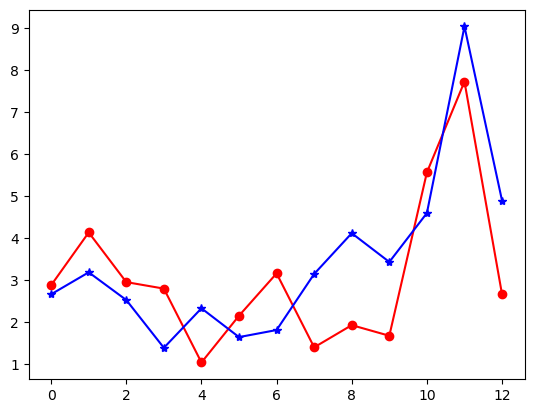

 train loss: 0.4868034430912563 validation loss: 0.010895902290940285
 train loss: 0.1414980982031141 validation loss: 0.5305484533309937
 train loss: 0.10399730929306575 validation loss: 0.1249648705124855
 train loss: 0.08663010597229004 validation loss: 0.0799664705991745
 train loss: 0.0691847089678049 validation loss: 0.4872419536113739
 train loss: 0.5312351558889662 validation loss: 0.1739329844713211
 train loss: 0.12526980420308453 validation loss: 0.46561795473098755
 train loss: 0.09676777465002877 validation loss: 0.5985175371170044
 train loss: 0.07765064580099923 validation loss: 0.5499436259269714
 train loss: 0.08040000689881188 validation loss: 0.47739309072494507
21 :  0.35615186393260956 [0.2994781732559204, 0.4128255546092987]
tensor(0.4094)


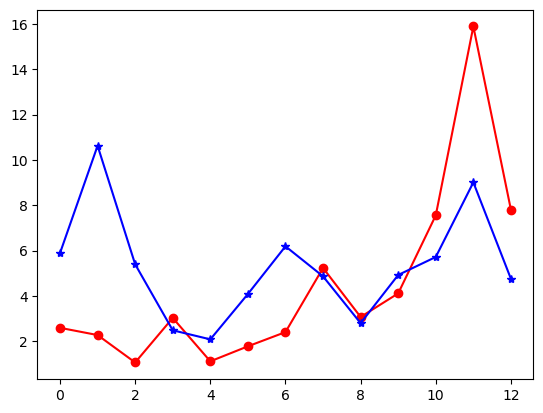

 train loss: 0.1949227831193379 validation loss: -0.0008223101613111794
 train loss: 0.11958171959434237 validation loss: 0.27980074286460876
 train loss: 0.06639967220170158 validation loss: 0.4983675479888916
 train loss: 0.056803855512823374 validation loss: 0.27809345722198486
 train loss: 0.04587572738528252 validation loss: 0.3350414037704468
 train loss: 0.30269985156399865 validation loss: -0.08329183608293533
 train loss: 0.10569056932415281 validation loss: 0.4388018846511841
 train loss: 0.08268126142876489 validation loss: 0.04776425287127495
 train loss: 0.0520757964679173 validation loss: -0.10833323746919632
 train loss: 0.03601096416158336 validation loss: 0.2615949511528015
22 :  0.12281529605388641 [0.05342908203601837, 0.19220151007175446]
tensor(0.1236)


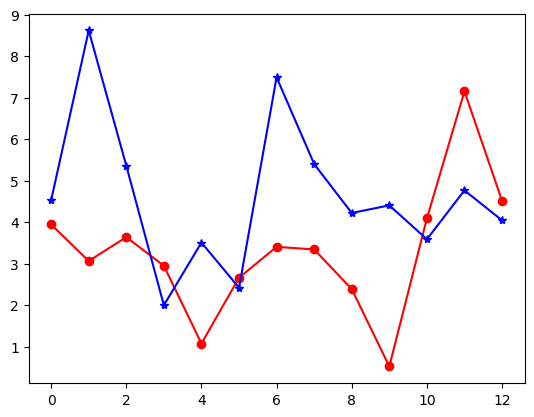

 train loss: 0.6107831980500903 validation loss: -0.011558359488844872
 train loss: 0.10543670356273652 validation loss: 0.636847972869873
 train loss: 0.07710190287658146 validation loss: 0.3357250690460205
 train loss: 0.07179371544292995 validation loss: 0.6346554160118103
 train loss: 0.042914047305073054 validation loss: 0.44732150435447693
 train loss: 0.570228556224278 validation loss: 0.2873099148273468
 train loss: 0.11123639664479665 validation loss: 0.34935271739959717
 train loss: 0.07854521849325725 validation loss: 0.6806640028953552
 train loss: 0.06477511477257525 validation loss: 0.45177990198135376
 train loss: 0.03725679357136999 validation loss: 0.5100046992301941
23 :  0.5355864018201828 [0.6049445867538452, 0.4662282168865204]
tensor(0.5789)


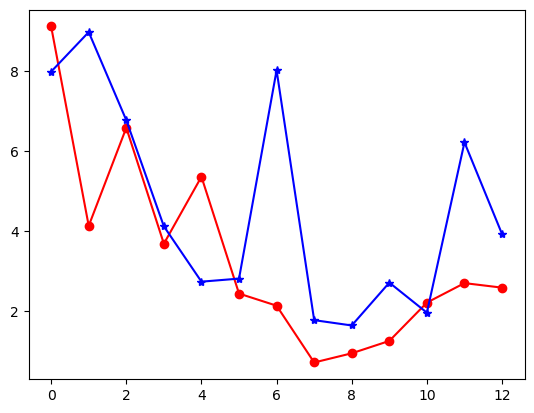

 train loss: 0.6333699400935854 validation loss: 0.08280761539936066
 train loss: 0.12863660454750062 validation loss: 0.30178260803222656
 train loss: 0.1019646459392139 validation loss: 0.4148123860359192
 train loss: 0.08761785072939736 validation loss: 0.5621702075004578
 train loss: 0.08163006284407207 validation loss: 0.78839510679245
 train loss: 0.4338341721466609 validation loss: -0.19526973366737366
 train loss: 0.14163486744676318 validation loss: 0.16677601635456085
 train loss: 0.09839617801564081 validation loss: 0.3790304660797119
 train loss: 0.06388941385916301 validation loss: 0.4365874230861664
 train loss: 0.062129918592316764 validation loss: 0.5840338468551636
24 :  0.4631925895810127 [0.6913904547691345, 0.23499472439289093]
tensor(0.6961)


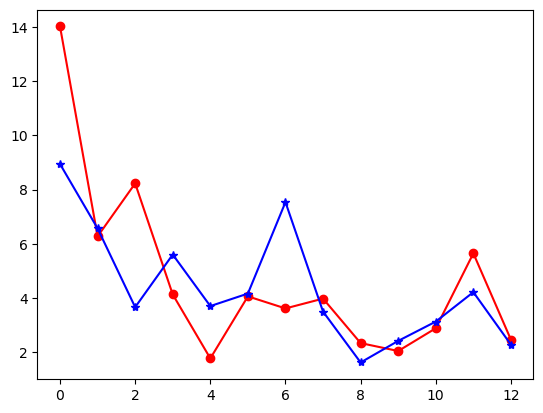

 train loss: 0.2312394495521273 validation loss: 0.2579253911972046
 train loss: 0.07986753902265004 validation loss: 0.13258564472198486
 train loss: 0.062535257052098 validation loss: 0.35231781005859375
 train loss: 0.05735463957701411 validation loss: 0.13960833847522736
 train loss: 0.0365667715136494 validation loss: 0.09019774198532104
 train loss: 0.23960466257163457 validation loss: 0.42186450958251953
 train loss: 0.08423115504639489 validation loss: 0.307415246963501
 train loss: 0.07284730577043125 validation loss: 0.37153488397598267
 train loss: 0.06127454819423812 validation loss: 0.4038574695587158
 train loss: 0.043233923933335715 validation loss: 0.45328766107559204
25 :  0.3290041536092758 [0.32103851437568665, 0.336969792842865]
tensor(0.5286)


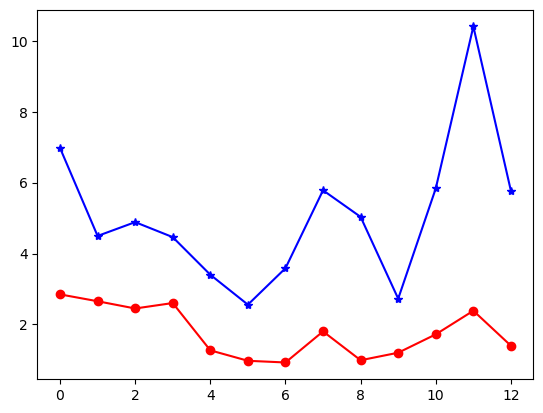

 train loss: 0.3727876859051841 validation loss: 0.4239254891872406
 train loss: 0.1284053432089942 validation loss: 0.5485742092132568
 train loss: 0.10418542176485061 validation loss: -0.1450633853673935
 train loss: 0.07487969845533371 validation loss: 0.42851537466049194
 train loss: 0.05991661335740771 validation loss: 0.4680449962615967
 train loss: 0.8427868025643485 validation loss: -0.14709199965000153
 train loss: 0.12185666912368366 validation loss: 0.22018936276435852
 train loss: 0.11911286222083228 validation loss: 0.552075982093811
 train loss: 0.11011121890374592 validation loss: 0.38657060265541077
 train loss: 0.07139141538313457 validation loss: 0.5421671867370605
26 :  0.410728856921196 [0.41847795248031616, 0.4029797613620758]
tensor(0.3474)


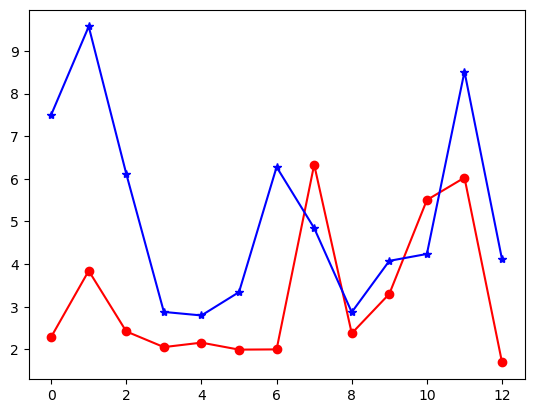

 train loss: 0.27850570593561447 validation loss: 0.06801126152276993
 train loss: 0.07809961544615882 validation loss: 0.4013754725456238
 train loss: 0.07743654059512274 validation loss: 0.501796305179596
 train loss: 0.06313778460025787 validation loss: 0.43959304690361023
 train loss: 0.0455728676702295 validation loss: 0.5868121981620789
 train loss: 0.3416419429438455 validation loss: 0.35294052958488464
 train loss: 0.07857210923518454 validation loss: 0.26700714230537415
 train loss: 0.06264233461448125 validation loss: 0.6301970481872559
 train loss: 0.0662925372166293 validation loss: 0.5171858668327332
 train loss: 0.04858762291925294 validation loss: 0.37112581729888916
27 :  0.30071812868118286 [0.2335277497768402, 0.3679085075855255]
tensor(0.4905)


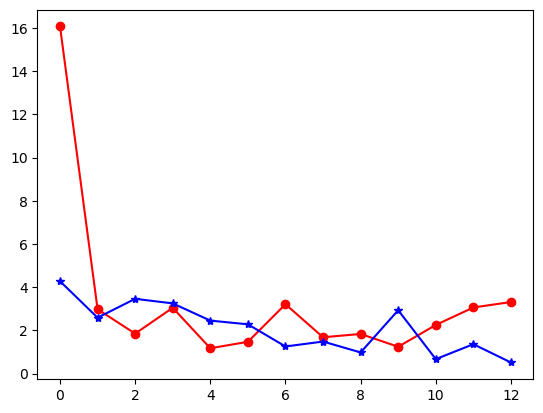

 train loss: 0.3542059289557593 validation loss: -0.05226479098200798
 train loss: 0.07838076470153672 validation loss: 0.6971920728683472
 train loss: 0.06414660406964166 validation loss: 0.7068672776222229
 train loss: 0.06378630293267114 validation loss: 0.43251070380210876
 train loss: 0.04374332523771695 validation loss: 0.6070517897605896
 train loss: 0.33044503927230834 validation loss: -0.294098436832428
 train loss: 0.08157957260097776 validation loss: 0.6655337810516357
 train loss: 0.06785221078566142 validation loss: 0.551964521408081
 train loss: 0.05843231805733272 validation loss: 0.4113071858882904
 train loss: 0.03622362996850695 validation loss: 0.5349482893943787
28 :  0.6587008237838745 [0.6743122339248657, 0.6430894136428833]
tensor(0.4567)


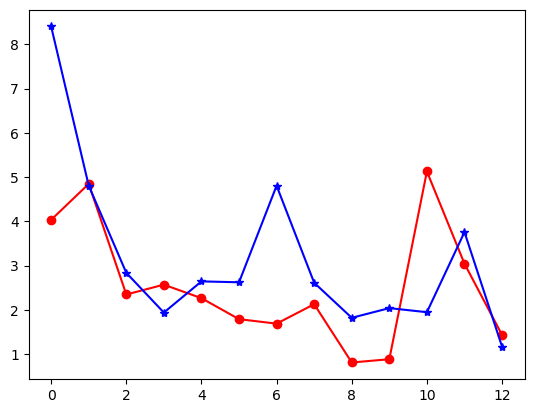

 train loss: 0.35644097115312307 validation loss: -0.17369046807289124
 train loss: 0.08355226718953677 validation loss: 0.63100266456604
 train loss: 0.06790808673415866 validation loss: 0.6216335296630859
 train loss: 0.047259797368730816 validation loss: 0.7262498736381531
 train loss: 0.041690856803740774 validation loss: 0.8248012661933899
 train loss: 0.30766292342117857 validation loss: -0.077472984790802
 train loss: 0.08102572773184095 validation loss: 0.7270528674125671
 train loss: 0.06812153565032142 validation loss: 0.8552277088165283
 train loss: 0.046996786072850225 validation loss: 0.7876408100128174
 train loss: 0.039601580266441616 validation loss: 0.7444260120391846
29 :  0.6149147748947144 [0.6131182312965393, 0.6167113184928894]
tensor(0.7377)


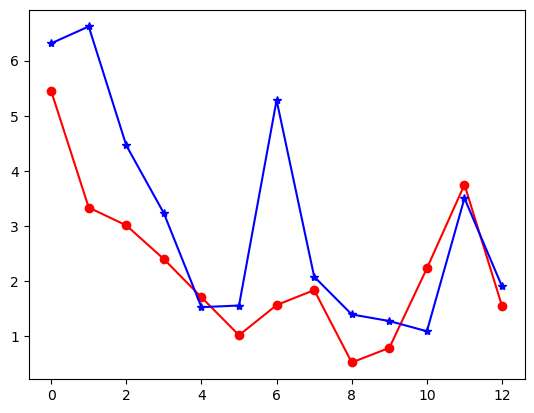

 train loss: 0.3264681854418346 validation loss: -0.03566939756274223
 train loss: 0.0951172758425985 validation loss: 0.6092967391014099
 train loss: 0.06338377648166248 validation loss: 0.8444520235061646
 train loss: 0.04387618824839592 validation loss: 0.5913407206535339
 train loss: 0.053707672016961236 validation loss: 0.6130073666572571
 train loss: 0.39370989884649005 validation loss: 0.12598393857479095
 train loss: 0.08342818128211157 validation loss: 0.7195537090301514
 train loss: 0.05842323702360903 validation loss: 0.7351922392845154
 train loss: 0.05700053476861545 validation loss: 0.6568849086761475
 train loss: 0.034933864218848094 validation loss: 0.6494495272636414
30 :  0.5195368677377701 [0.456205815076828, 0.5828679203987122]
tensor(0.6158)


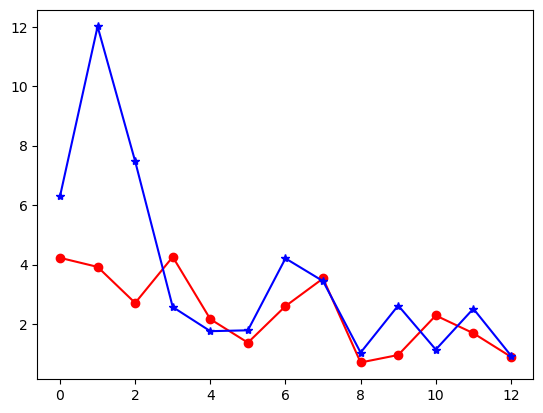

 train loss: 0.17164280925478254 validation loss: 0.5212894678115845
 train loss: 0.0698514176266534 validation loss: 0.16822701692581177
 train loss: 0.0553522989153862 validation loss: 0.35405293107032776
 train loss: 0.03978926789547716 validation loss: 0.6468061804771423
 train loss: 0.030023184259022985 validation loss: 0.6075194478034973
 train loss: 0.7479246054376875 validation loss: 0.13191919028759003
 train loss: 0.09309375094515937 validation loss: 0.5572801232337952
 train loss: 0.05641483526144709 validation loss: 0.4754268527030945
 train loss: 0.0426601979881525 validation loss: 0.5378283858299255
 train loss: 0.031170463508793284 validation loss: 0.5453980565071106
31 :  0.3335249423980713 [0.390175998210907, 0.2768738865852356]
tensor(0.7120)


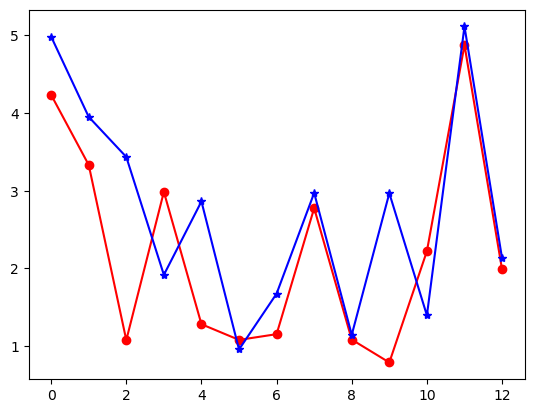

 train loss: 0.39654928765126635 validation loss: 0.320097416639328
 train loss: 0.11669199232544218 validation loss: 0.009994948282837868
 train loss: 0.08396576387541635 validation loss: 0.4683416783809662
 train loss: 0.059021435465131486 validation loss: 0.4524439573287964
 train loss: 0.06236619667283126 validation loss: -0.12686149775981903
 train loss: 0.5391278828893389 validation loss: -0.33431845903396606
 train loss: 0.10921544496502195 validation loss: 0.3552872836589813
 train loss: 0.07625767758914402 validation loss: -0.1680208295583725
 train loss: 0.06399630223001752 validation loss: -0.2593284845352173
 train loss: 0.051923299155064995 validation loss: -0.09690269082784653
32 :  0.04351574182510376 [0.2591690421104431, -0.1721375584602356]
tensor(-0.4194)


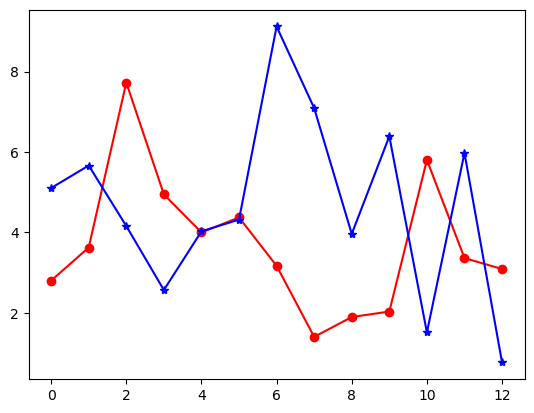

 train loss: 0.18763947870050157 validation loss: 0.11084862053394318
 train loss: 0.07363461405038833 validation loss: 0.5085709095001221
 train loss: 0.058106570797307154 validation loss: 0.49579745531082153
 train loss: 0.04493472650647164 validation loss: 0.7542393207550049
 train loss: 0.03680535081241812 validation loss: 0.411110520362854
 train loss: 0.4897271718297686 validation loss: 0.5067083239555359
 train loss: 0.09484812255416597 validation loss: 0.03841371089220047
 train loss: 0.0643116788140365 validation loss: 0.5270468592643738
 train loss: 0.046724805448736466 validation loss: 0.6836413145065308
 train loss: 0.03908043046082769 validation loss: 0.5935561656951904
33 :  0.5319805294275284 [0.39445140957832336, 0.6695096492767334]
tensor(0.6158)


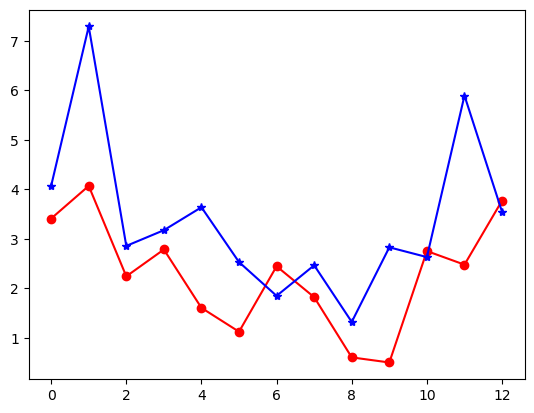

 train loss: 0.366916789327349 validation loss: -0.536845862865448
 train loss: 0.14827969361628804 validation loss: 0.5608996748924255
 train loss: 0.10844590472323554 validation loss: 0.5615134835243225
 train loss: 0.07103804711784635 validation loss: 0.3865833580493927
 train loss: 0.03692130680595126 validation loss: 0.13545897603034973
 train loss: 0.3581514367035457 validation loss: -0.02315807342529297
 train loss: 0.15026136189699174 validation loss: 0.21093010902404785
 train loss: 0.12891734753336226 validation loss: 0.18195553123950958
 train loss: 0.10028668514319829 validation loss: 0.39380088448524475
 train loss: 0.06769005496587072 validation loss: -0.010396323166787624
34 :  0.018022656440734863 [-0.10538670420646667, 0.1414320170879364]
tensor(0.1757)


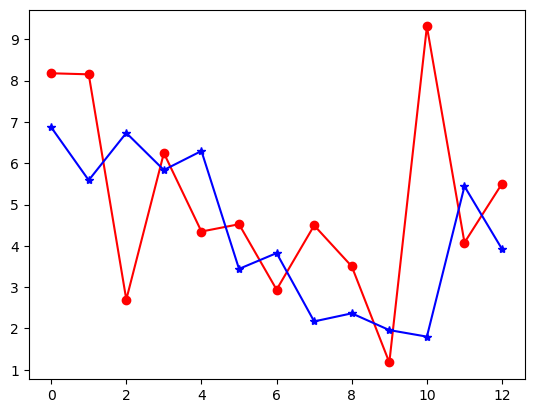

 train loss: 0.3275327001299177 validation loss: 0.040755029767751694
 train loss: 0.09455392147813524 validation loss: 0.30322688817977905
 train loss: 0.07078098037413189 validation loss: 0.48883992433547974
 train loss: 0.06819407609956606 validation loss: 0.4083664119243622
 train loss: 0.049480622155325754 validation loss: 0.48088937997817993
 train loss: 0.412789637701852 validation loss: 0.1824062466621399
 train loss: 0.09142706628356662 validation loss: 0.5683035850524902
 train loss: 0.07569938280752726 validation loss: 0.6658414006233215
 train loss: 0.05432473261441503 validation loss: 0.49028128385543823
 train loss: 0.04690620100923947 validation loss: 0.43603515625
35 :  0.47874149680137634 [0.6745228171348572, 0.2829601764678955]
tensor(0.7333)


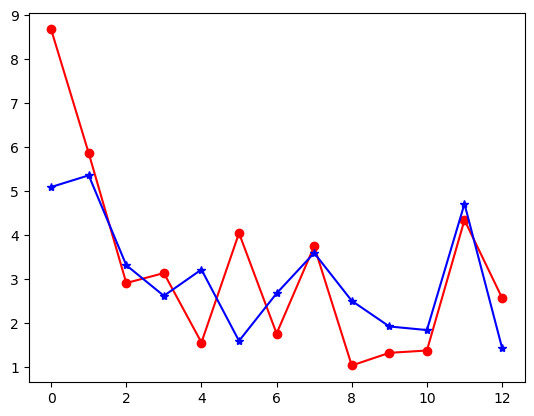

 train loss: 0.2489711514541081 validation loss: 0.1743958592414856
 train loss: 0.07841713981969016 validation loss: -0.23576030135154724
 train loss: 0.0501934609242848 validation loss: 0.09932127594947815
 train loss: 0.04679445996880531 validation loss: 0.3608956038951874
 train loss: 0.04100541653377669 validation loss: 0.6660362482070923
 train loss: 0.23092799974339348 validation loss: 0.13402771949768066
 train loss: 0.07849285410983221 validation loss: 0.037897251546382904
 train loss: 0.05646648651787213 validation loss: 0.22008010745048523
 train loss: 0.03141497245856694 validation loss: 0.5147708058357239
 train loss: 0.03125904348811933 validation loss: 0.38612592220306396
36 :  0.4146333932876587 [0.3978847861289978, 0.4313820004463196]
tensor(0.1155)


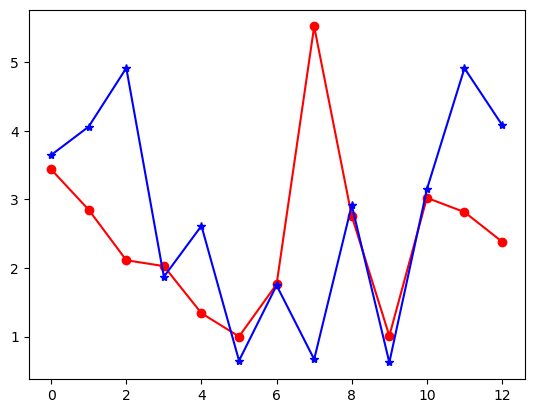

 train loss: 0.279479689683233 validation loss: -0.3843565583229065
 train loss: 0.11960254811814854 validation loss: -0.023001302033662796
 train loss: 0.11129226173673357 validation loss: 0.10982849448919296
 train loss: 0.08989012730973107 validation loss: -0.08238104730844498
 train loss: 0.07046115595315183 validation loss: 0.08585025370121002
 train loss: 0.5187593391963414 validation loss: 0.0897136777639389
 train loss: 0.10547546084438052 validation loss: 0.12306591123342514
 train loss: 0.10188438126019068 validation loss: -0.35515984892845154
 train loss: 0.08972594408052308 validation loss: 0.2791310250759125
 train loss: 0.061768372782639094 validation loss: 0.49131661653518677
37 :  -0.10806689038872719 [-0.3236881494522095, 0.1075543686747551]
tensor(0.4166)


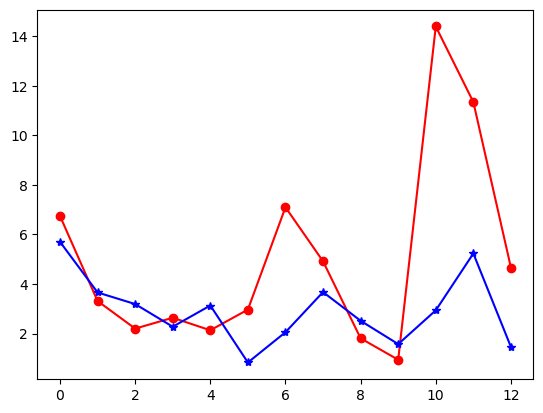

 train loss: 0.4160253414085933 validation loss: 0.43146654963493347
 train loss: 0.10479439944028854 validation loss: 0.1932835727930069
 train loss: 0.07144498729280063 validation loss: 0.06236499547958374
 train loss: 0.06960469473685538 validation loss: 0.2624167799949646
 train loss: 0.04933383102927889 validation loss: 0.6181753277778625
 train loss: 0.41427367755344935 validation loss: 0.17151860892772675
 train loss: 0.10070493412869318 validation loss: 0.08501696586608887
 train loss: 0.07307967245578766 validation loss: 0.4193926155567169
 train loss: 0.05884965945567403 validation loss: 0.28288424015045166
 train loss: 0.04654642998107842 validation loss: 0.3687809407711029
38 :  0.27428046613931656 [0.2245262712240219, 0.3240346610546112]
tensor(0.4449)


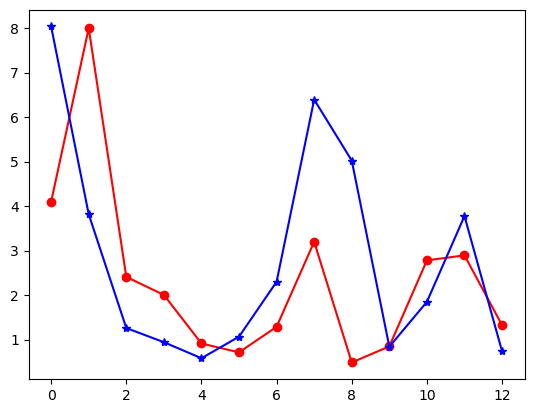

 train loss: 0.6908849579947335 validation loss: -0.6268087029457092
 train loss: 0.13144746805940355 validation loss: 0.13003696501255035
 train loss: 0.09723137936421804 validation loss: 0.15759728848934174
 train loss: 0.07390901829515184 validation loss: 0.2614904046058655
 train loss: 0.0619334132543632 validation loss: 0.3141108453273773
 train loss: 0.9297821704830442 validation loss: -0.44995152950286865
 train loss: 0.10028045081666538 validation loss: 0.3718259930610657
 train loss: 0.09183006488851138 validation loss: 0.45649072527885437
 train loss: 0.07809695824980736 validation loss: 0.3847711384296417
 train loss: 0.07235024246786322 validation loss: 0.219418004155159
39 :  0.2449398934841156 [0.1577531099319458, 0.3321266770362854]
tensor(0.4545)


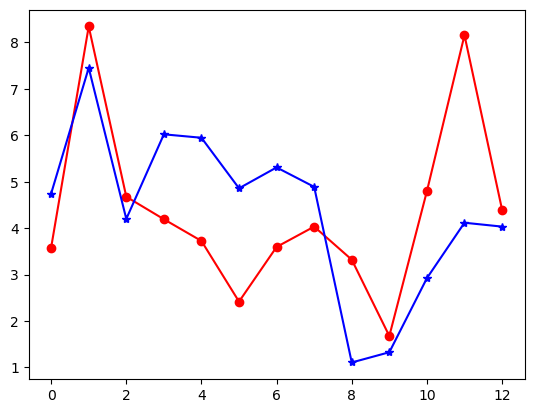

 train loss: 0.29887601179736 validation loss: 0.004654770717024803
 train loss: 0.07368940019181797 validation loss: 0.8073437809944153
 train loss: 0.06684582914624895 validation loss: 0.21671220660209656
 train loss: 0.04172652012535504 validation loss: 0.26010236144065857
 train loss: 0.05488428409610476 validation loss: 0.22167551517486572
 train loss: 0.41359451285430365 validation loss: -0.11632056534290314
 train loss: 0.07922401076980999 validation loss: 0.4411986470222473
 train loss: 0.053463012778333256 validation loss: 0.24603694677352905
 train loss: 0.04866630839450019 validation loss: 0.45122766494750977
 train loss: 0.04346084892749787 validation loss: 0.26314833760261536
40 :  0.32715657353401184 [0.47723761200904846, 0.17707553505897522]
tensor(-0.0019)


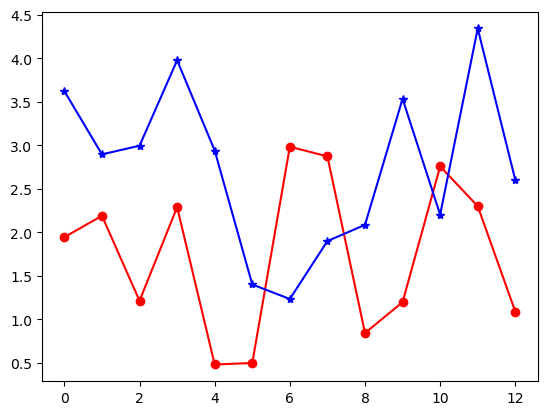

 train loss: 0.18167617278439657 validation loss: -0.05760405957698822
 train loss: 0.07321214314017976 validation loss: 0.6443181037902832
 train loss: 0.048549260411943705 validation loss: 0.6950672268867493
 train loss: 0.03705521896481514 validation loss: 0.620512068271637
 train loss: 0.026912883136953628 validation loss: 0.36403653025627136
 train loss: 0.23013427427836827 validation loss: -0.1977081447839737
 train loss: 0.0814442084303924 validation loss: 0.23986122012138367
 train loss: 0.048959025740623476 validation loss: 0.3021559715270996
 train loss: 0.045635553635656835 validation loss: 0.6141451597213745
 train loss: 0.03057393841445446 validation loss: 0.48947831988334656
41 :  0.474274605512619 [0.6278558373451233, 0.32069337368011475]
tensor(0.4934)


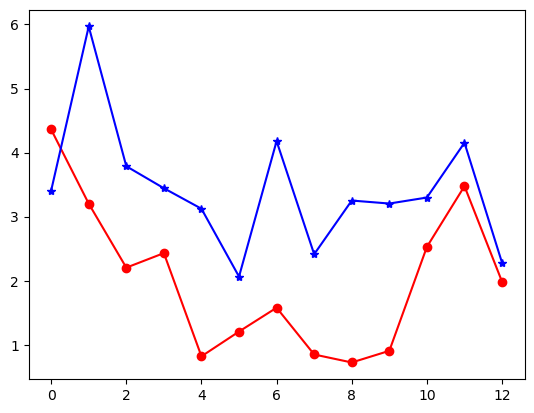

 train loss: 0.23636964687279294 validation loss: 0.23167991638183594
 train loss: 0.07426310192261423 validation loss: 0.7583408951759338
 train loss: 0.05392580032348633 validation loss: 0.7532732486724854
 train loss: 0.053074302950075695 validation loss: 0.7183647751808167
 train loss: 0.03936458980398519 validation loss: 0.8900907635688782
 train loss: 0.36242649129458837 validation loss: 0.1590820997953415
 train loss: 0.08390871669564928 validation loss: 0.7673210501670837
 train loss: 0.06002192699483463 validation loss: 0.8270705342292786
 train loss: 0.04496112455214773 validation loss: 0.7538009881973267
 train loss: 0.040830560507518904 validation loss: 0.8506697416305542
42 :  0.7785479426383972 [0.8259463310241699, 0.7311495542526245]
tensor(0.8572)


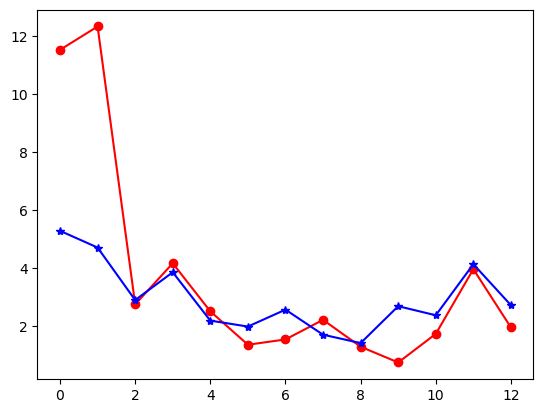

 train loss: 0.3211511377777372 validation loss: -0.31552401185035706
 train loss: 0.10181749697242465 validation loss: 0.24231202900409698
 train loss: 0.08144145097051347 validation loss: 0.07036945223808289
 train loss: 0.058258742839097974 validation loss: 0.18477608263492584
 train loss: 0.05953193200486047 validation loss: 0.17495743930339813
 train loss: 0.5009315720626286 validation loss: 0.1821361631155014
 train loss: 0.11942009116922106 validation loss: -0.11944913119077682
 train loss: 0.09440286074365889 validation loss: 0.1925031989812851
 train loss: 0.06954561642238072 validation loss: 0.3186822533607483
 train loss: 0.05690526983567647 validation loss: 0.04592060670256615
43 :  -0.05357911437749863 [-0.05378766730427742, -0.05337056145071983]
tensor(0.3351)


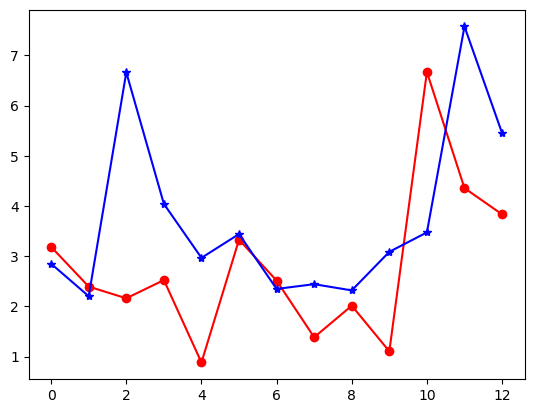

 train loss: 0.34088706501892635 validation loss: -0.23718176782131195
 train loss: 0.1682520124529089 validation loss: 0.5449380278587341
 train loss: 0.144818557373115 validation loss: -0.22102069854736328
 train loss: 0.11497228901301111 validation loss: -0.11387949436903
 train loss: 0.11480128190347126 validation loss: 0.2475724220275879
 train loss: 0.6084594675472804 validation loss: 0.30204224586486816
 train loss: 0.20347640173775808 validation loss: -0.04727144539356232
 train loss: 0.1537711283990315 validation loss: 0.36202946305274963
 train loss: 0.15277690908738545 validation loss: 0.509781002998352
 train loss: 0.10620085448026657 validation loss: 0.4094327688217163
44 :  0.3621836006641388 [0.5233047008514404, 0.20106250047683716]
tensor(0.3358)


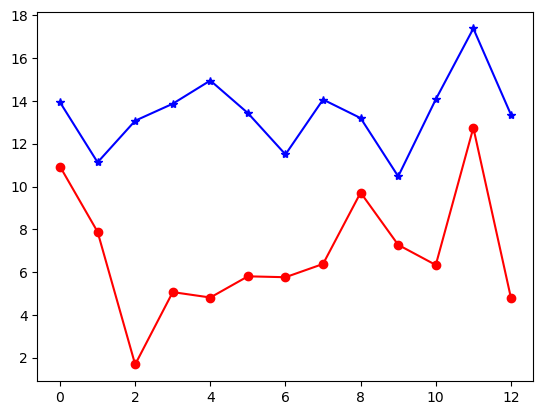

 train loss: 0.30044643091303963 validation loss: 0.26145628094673157
 train loss: 0.13742667990071433 validation loss: -0.09364742785692215
 train loss: 0.08882194757461548 validation loss: -0.004438185133039951
 train loss: 0.07727848323328154 validation loss: 0.2792627811431885
 train loss: 0.05428142749837467 validation loss: 0.1770249754190445
 train loss: 0.2826984677995954 validation loss: -0.5088399648666382
 train loss: 0.12504625884549958 validation loss: 0.27731242775917053
 train loss: 0.08390354019190584 validation loss: 0.4615461826324463
 train loss: 0.06776734675679888 validation loss: 0.5887135863304138
 train loss: 0.07487276845744678 validation loss: 0.5995351672172546
45 :  0.631420910358429 [0.5136312246322632, 0.7492105960845947]
tensor(0.5744)


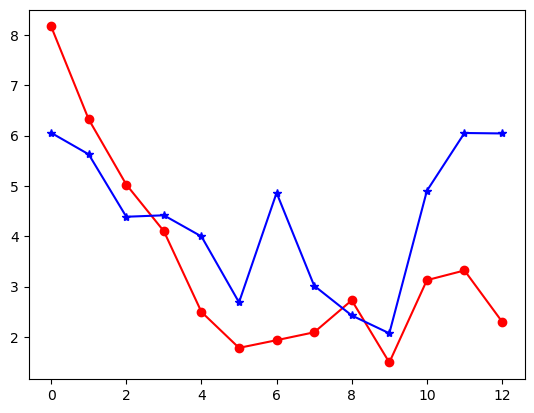

 train loss: 0.43101122890199933 validation loss: 0.19165126979351044
 train loss: 0.11894925385713577 validation loss: 0.5327237844467163
 train loss: 0.09626186617783138 validation loss: 0.8120288848876953
 train loss: 0.08764331787824631 validation loss: 0.5485594272613525
 train loss: 0.055156822715486796 validation loss: 0.5355915427207947
 train loss: 0.5147134593554905 validation loss: 0.2766128480434418
 train loss: 0.11502274977309364 validation loss: 0.6625664830207825
 train loss: 0.09358734658786229 validation loss: 0.5609982013702393
 train loss: 0.08240072120513235 validation loss: 0.5773555636405945
 train loss: 0.05343975525881563 validation loss: 0.6897900700569153
46 :  0.5711110979318619 [0.6812633872032166, 0.4609588086605072]
tensor(0.6780)


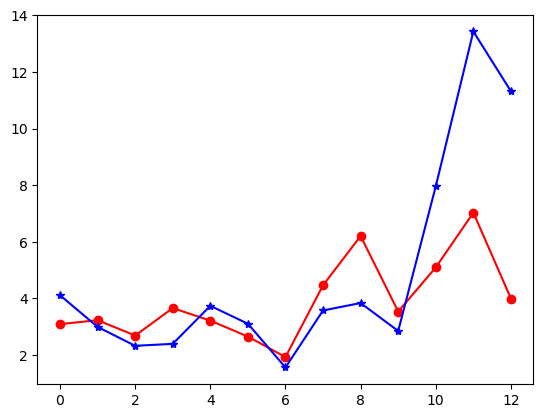

 train loss: 0.3072217059986932 validation loss: 0.03498364984989166
 train loss: 0.09639066479035786 validation loss: 0.6986048817634583
 train loss: 0.06706317327916622 validation loss: 0.5051811337471008
 train loss: 0.0581320373075349 validation loss: 0.713989794254303
 train loss: 0.04756499177643231 validation loss: 0.6716840863227844
 train loss: 0.2174832718712943 validation loss: 0.13088089227676392
 train loss: 0.08387343292789799 validation loss: 0.6318352222442627
 train loss: 0.06292675701635224 validation loss: 0.5102329850196838
 train loss: 0.04869554154574871 validation loss: 0.8948048949241638
 train loss: 0.03631457058446748 validation loss: 0.6070052981376648
47 :  0.658498078584671 [0.6939518451690674, 0.6230443120002747]
tensor(0.6610)


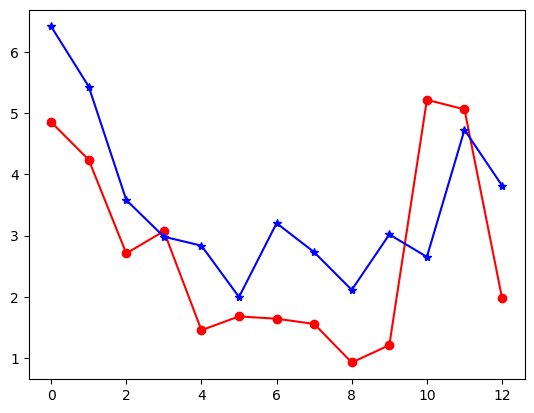

 train loss: 0.4246063981737409 validation loss: -0.20624615252017975
 train loss: 0.14926869443484714 validation loss: -0.014599117450416088
 train loss: 0.0926665825503213 validation loss: 0.5453245043754578
 train loss: 0.10176346323319845 validation loss: 0.3363616466522217
 train loss: 0.07952245803815979 validation loss: 0.5355597734451294
 train loss: 1.0159093746117183 validation loss: 0.08230152726173401
 train loss: 0.13890843157257352 validation loss: -0.007892375811934471
 train loss: 0.09756803895745958 validation loss: 0.16811667382717133
 train loss: 0.07301049679517746 validation loss: 0.6590846180915833
 train loss: 0.07061109234179769 validation loss: 0.7063465118408203
48 :  0.5425387173891068 [0.6122053265571594, 0.4728721082210541]
tensor(0.3389)


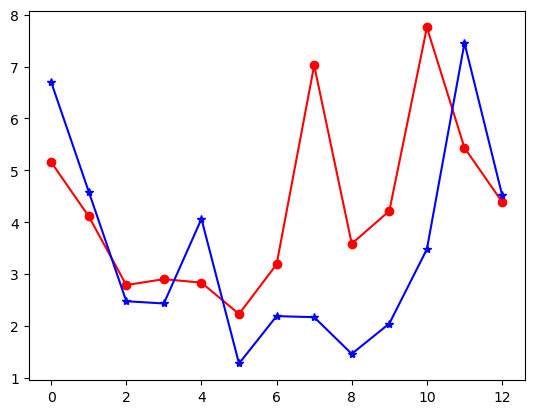

 train loss: 0.35197591185569765 validation loss: -0.10347051173448563
 train loss: 0.09222399124077388 validation loss: 0.10784005373716354
 train loss: 0.07966261059045791 validation loss: -0.14293138682842255
 train loss: 0.06740632514868464 validation loss: 0.22639921307563782
 train loss: 0.06063393460852759 validation loss: 0.03669087588787079
 train loss: 0.603059959411621 validation loss: -0.16427019238471985
 train loss: 0.13937707543373107 validation loss: -0.14230388402938843
 train loss: 0.09645196667739324 validation loss: -0.3713208734989166
 train loss: 0.07859304760183607 validation loss: -0.1091236025094986
 train loss: 0.055703614013535636 validation loss: 0.25457409024238586
49 :  0.10528263449668884 [0.11873187124729156, 0.09183339774608612]
tensor(0.0872)


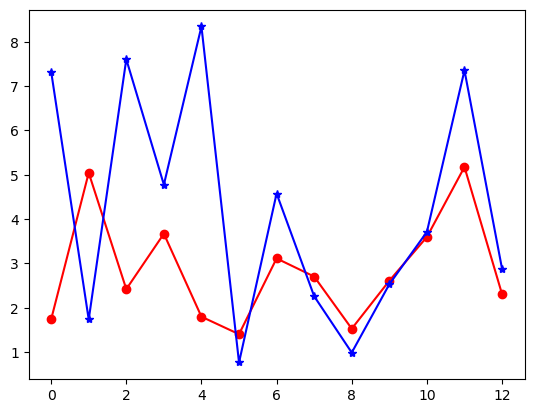

 train loss: 0.3864612349442073 validation loss: 0.2768040895462036
 train loss: 0.12799653347049442 validation loss: 0.15326730906963348
 train loss: 0.09978456624916622 validation loss: -0.09054062515497208
 train loss: 0.0860146477818489 validation loss: 0.5926227569580078
 train loss: 0.06123115015881402 validation loss: 0.40317755937576294
 train loss: 0.27383558239255634 validation loss: -0.0051713548600673676
 train loss: 0.1273156476872308 validation loss: 0.05809885263442993
 train loss: 0.10355715794222696 validation loss: -0.13584880530834198
 train loss: 0.08866998489413942 validation loss: 0.12083657085895538
 train loss: 0.07700547746249607 validation loss: 0.49280846118927
50 :  0.3135022521018982 [0.3935893774032593, 0.2334151268005371]
tensor(0.2051)


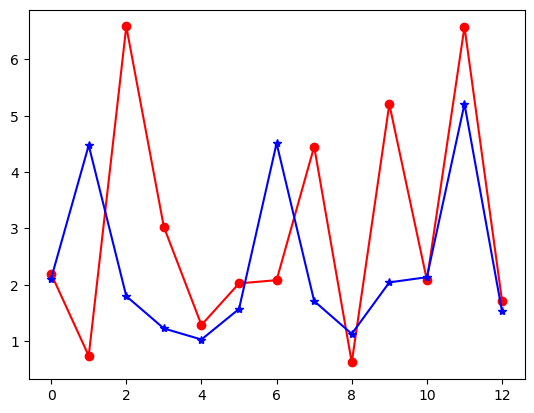

 train loss: 0.19729514718055724 validation loss: -0.09633243083953857
 train loss: 0.0959654915545668 validation loss: 0.2917321026325226
 train loss: 0.05459534621664456 validation loss: 0.22025498747825623
 train loss: 0.04918682160122054 validation loss: -0.48405542969703674
 train loss: 0.04056402929127216 validation loss: 0.006714970804750919
 train loss: 0.30042589604854586 validation loss: -0.3657916486263275
 train loss: 0.08418540933302471 validation loss: 0.07841255515813828
 train loss: 0.06276170451726232 validation loss: 0.4368380308151245
 train loss: 0.059922867587634494 validation loss: 0.11023783683776855
 train loss: 0.04011021799274853 validation loss: -0.2719663977622986
51 :  -0.016654886305332184 [0.15993113815784454, -0.1932409107685089]
tensor(-0.2155)


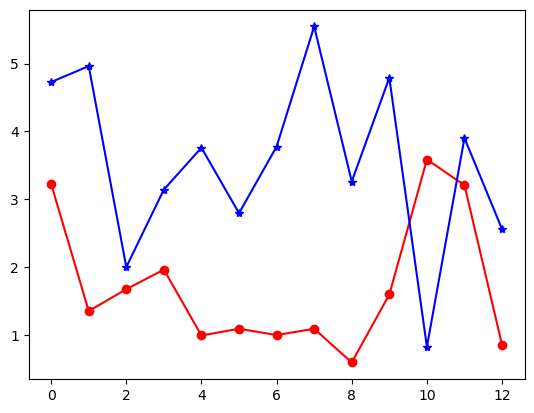

 train loss: 0.28828731807214875 validation loss: 0.010561807081103325
 train loss: 0.10777733400464058 validation loss: 0.5427501201629639
 train loss: 0.06686324360115188 validation loss: 0.2579067051410675
 train loss: 0.05994828790426254 validation loss: 0.66014564037323
 train loss: 0.0377859503030777 validation loss: 0.7065516114234924
 train loss: 0.33948931183133807 validation loss: -0.3621954917907715
 train loss: 0.12071133798786572 validation loss: 0.5706679821014404
 train loss: 0.05790875085762569 validation loss: 0.4945051372051239
 train loss: 0.05155888881002154 validation loss: 0.5144069194793701
 train loss: 0.039972241701824326 validation loss: 0.6725029349327087
52 :  0.6193353533744812 [0.6929332613945007, 0.5457374453544617]
tensor(0.5761)


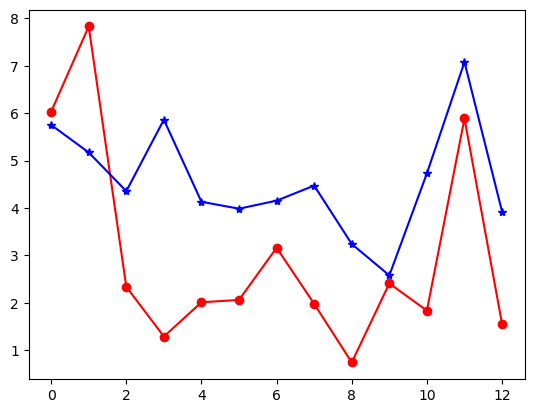

 train loss: 0.6623622741018023 validation loss: 0.28584834933280945
 train loss: 0.11881911690746035 validation loss: 0.1870267540216446
 train loss: 0.09528615027666092 validation loss: 0.011542067863047123
 train loss: 0.06752146322812352 validation loss: 0.023574024438858032
 train loss: 0.048075301838772636 validation loss: 0.3435038626194
 train loss: 0.39835900706904276 validation loss: 0.26540204882621765
 train loss: 0.1100631730897086 validation loss: -0.12100531905889511
 train loss: 0.08470365075128419 validation loss: 0.0931168794631958
 train loss: 0.05720738960163934 validation loss: 0.03096795827150345
 train loss: 0.06138645080583436 validation loss: 0.3371940851211548
53 :  0.21428856998682022 [0.2618544399738312, 0.16672269999980927]
tensor(0.0948)


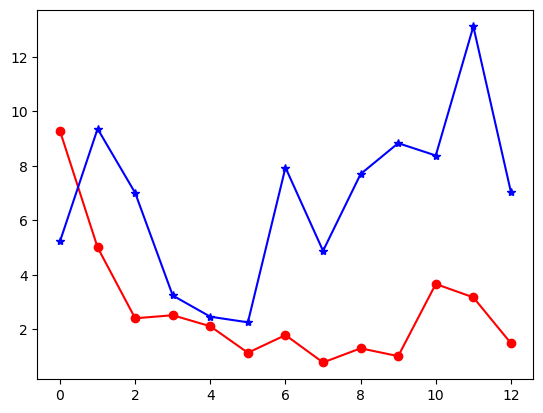

 train loss: 0.3857639678886959 validation loss: -0.15921969711780548
 train loss: 0.06892366749899728 validation loss: 0.4253385066986084
 train loss: 0.06113567267145429 validation loss: 0.5756561756134033
 train loss: 0.04204020446964673 validation loss: 0.6161364912986755
 train loss: 0.03602060380258731 validation loss: 0.4232679009437561
 train loss: 0.324142895426069 validation loss: 0.5401471257209778
 train loss: 0.087191903591156 validation loss: 0.6388399600982666
 train loss: 0.06430127998547895 validation loss: 0.6053447723388672
 train loss: 0.05526430213025638 validation loss: 0.5176853537559509
 train loss: 0.04014174310224397 validation loss: 0.568175196647644
54 :  0.4197607785463333 [0.3636336922645569, 0.47588786482810974]
tensor(0.5626)


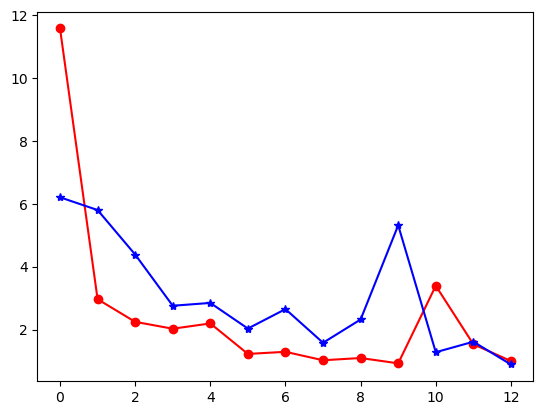

 train loss: 0.4096077024936676 validation loss: 0.13351137936115265
 train loss: 0.11891819196087973 validation loss: 0.6259515285491943
 train loss: 0.0981576036129679 validation loss: 0.48097798228263855
 train loss: 0.07586231024137564 validation loss: 0.6343705654144287
 train loss: 0.07094899767211506 validation loss: 0.7175585031509399
 train loss: 0.37327859146254405 validation loss: 0.6497188806533813
 train loss: 0.1207583120891026 validation loss: 0.3355761170387268
 train loss: 0.09154455810785293 validation loss: 0.6433659195899963
 train loss: 0.06247876669679369 validation loss: 0.42403408885002136
 train loss: 0.04430276485426085 validation loss: 0.5721101760864258
55 :  0.5933456718921661 [0.6194930672645569, 0.5671982765197754]
tensor(0.7110)


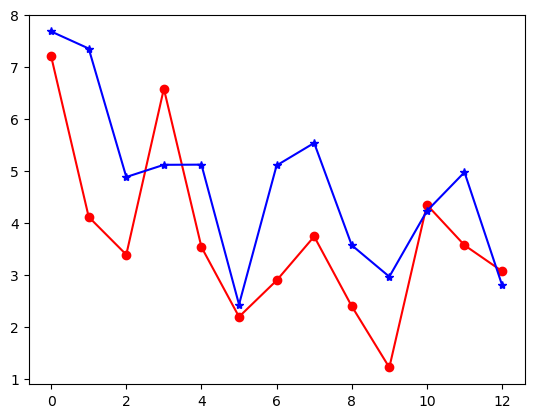

 train loss: 0.4149088723318917 validation loss: -0.24064283072948456
 train loss: 0.1060102468090398 validation loss: 0.28224554657936096
 train loss: 0.0879393112978765 validation loss: -0.0889982059597969
 train loss: 0.06321704408952168 validation loss: -0.5428534150123596
 train loss: 0.05609107347471373 validation loss: -0.3537209630012512
 train loss: 0.3867263683250972 validation loss: -0.4080297648906708
 train loss: 0.11500316687992641 validation loss: -0.24538229405879974
 train loss: 0.07916500940918922 validation loss: -0.4998866617679596
 train loss: 0.06005196049809456 validation loss: -0.5874765515327454
 train loss: 0.049440910507525714 validation loss: -0.38787373900413513
56 :  -0.35244255512952805 [-0.23116819560527802, -0.4737169146537781]
tensor(-0.2989)


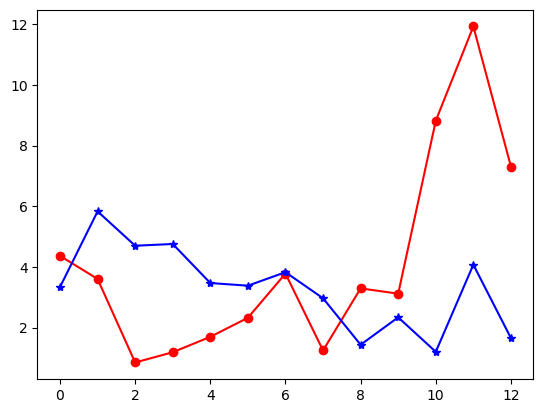

 train loss: 0.28900333770683834 validation loss: -0.04557488113641739
 train loss: 0.10169707408973148 validation loss: 0.35142165422439575
 train loss: 0.07183573224714825 validation loss: 0.6027740240097046
 train loss: 0.05356870565031256 validation loss: 0.3934946358203888
 train loss: 0.04872821910040719 validation loss: 0.5067473649978638
 train loss: 0.28654507739203317 validation loss: -0.09594205766916275
 train loss: 0.08632163447993142 validation loss: 0.6449422836303711
 train loss: 0.0698496770645891 validation loss: 0.458274781703949
 train loss: 0.04598093533090183 validation loss: 0.6188297867774963
 train loss: 0.04059596934488841 validation loss: 0.24602867662906647
57 :  0.4748961701989174 [0.7999662756919861, 0.1498260647058487]
tensor(0.2709)


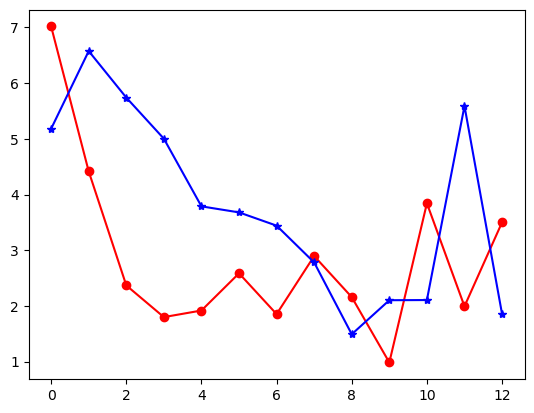

 train loss: 0.2925968853490693 validation loss: 0.03932291641831398
 train loss: 0.07666993290185928 validation loss: 0.2756439447402954
 train loss: 0.049419167371732846 validation loss: 0.16814826428890228
 train loss: 0.04153988350714956 validation loss: 0.4650036096572876
 train loss: 0.03663022236100265 validation loss: 0.4524097144603729
 train loss: 0.36064255216291974 validation loss: -0.21224482357501984
 train loss: 0.08408247381448745 validation loss: 0.7187767028808594
 train loss: 0.06670568723763738 validation loss: 0.47501513361930847
 train loss: 0.04485221984130996 validation loss: 0.28663018345832825
 train loss: 0.046222102801714626 validation loss: 0.43693676590919495
58 :  0.19887783378362656 [0.23907257616519928, 0.15868309140205383]
tensor(0.5288)


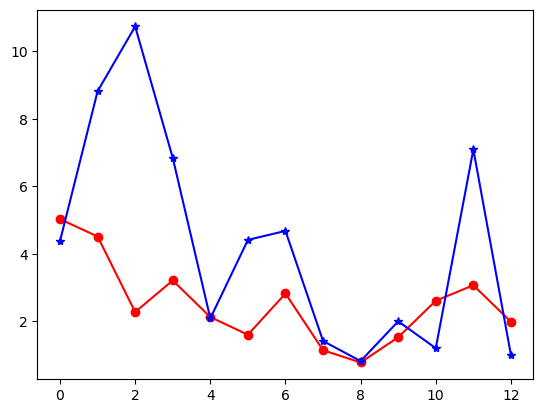

 train loss: 0.5198170512914657 validation loss: 0.04655981808900833
 train loss: 0.08079280746834619 validation loss: 0.36707836389541626
 train loss: 0.05383408559220178 validation loss: 0.3190602660179138
 train loss: 0.046121648060423986 validation loss: 0.3421826660633087
 train loss: 0.031959899328649045 validation loss: -0.26208895444869995
 train loss: 0.29901293537446433 validation loss: 0.3382425904273987
 train loss: 0.0772309198975563 validation loss: 0.3251314163208008
 train loss: 0.06284185945987701 validation loss: 0.1761394888162613
 train loss: 0.05276450089045933 validation loss: 0.492101788520813
 train loss: 0.03631913917405265 validation loss: 0.16449689865112305
59 :  0.4373149424791336 [0.6417612433433533, 0.23286864161491394]
tensor(0.0334)


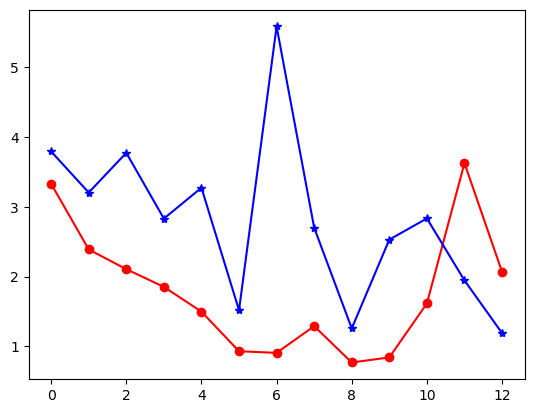

 train loss: 0.4651132609163012 validation loss: -0.2629047930240631
 train loss: 0.09471160365002496 validation loss: 0.7694535851478577
 train loss: 0.06729130776865141 validation loss: 0.7067855000495911
 train loss: 0.056133596066917694 validation loss: 0.5792636871337891
 train loss: 0.044774990209511346 validation loss: 0.2578219473361969
 train loss: 0.4383722530944007 validation loss: 0.5252178907394409
 train loss: 0.091842926719359 validation loss: 0.6273791790008545
 train loss: 0.05669036017996924 validation loss: 0.7397140264511108
 train loss: 0.039762661286762785 validation loss: 0.4603727161884308
 train loss: 0.03292547706514597 validation loss: 0.7451977729797363
60 :  0.6173182725906372 [0.5343557596206665, 0.7002807855606079]
tensor(0.6311)


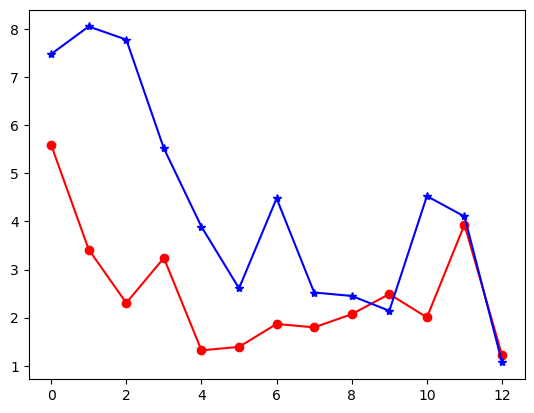

 train loss: 0.23043161290032524 validation loss: 0.3869180977344513
 train loss: 0.08398895221097129 validation loss: -0.42171457409858704
 train loss: 0.05437463383589472 validation loss: 0.1510697454214096
 train loss: 0.04582488504903657 validation loss: -0.3530733287334442
 train loss: 0.043858238948243006 validation loss: 0.22547586262226105
 train loss: 0.2922821074724197 validation loss: 0.3159090280532837
 train loss: 0.07755397771086012 validation loss: 0.06848078966140747
 train loss: 0.07093062230518886 validation loss: -0.0750880017876625
 train loss: 0.05895963545356478 validation loss: 0.5363572835922241
 train loss: 0.045009171962738036 validation loss: 0.11585822701454163
61 :  0.18077733740210533 [0.24794568121433258, 0.11360899358987808]
tensor(0.1193)


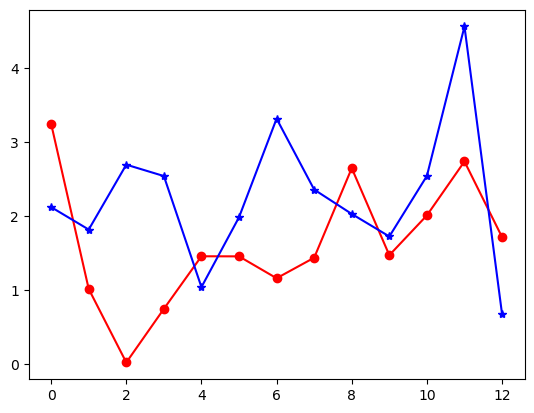

 train loss: 0.33829427531787326 validation loss: 0.605787992477417
 train loss: 0.0786344968846866 validation loss: 0.4574815034866333
 train loss: 0.051386127727372305 validation loss: 0.5582754611968994
 train loss: 0.05416765840990203 validation loss: 0.5281882286071777
 train loss: 0.04320386573672295 validation loss: 0.08882619440555573
 train loss: 0.41257589544568746 validation loss: -0.27217182517051697
 train loss: 0.09615237308400018 validation loss: -0.43841609358787537
 train loss: 0.07261719671743257 validation loss: 0.3149142861366272
 train loss: 0.048309212923049925 validation loss: 0.11941065639257431
 train loss: 0.04260845759085247 validation loss: 0.383218914270401
62 :  0.20538397133350372 [-0.12594130635261536, 0.5367092490196228]
tensor(0.7479)


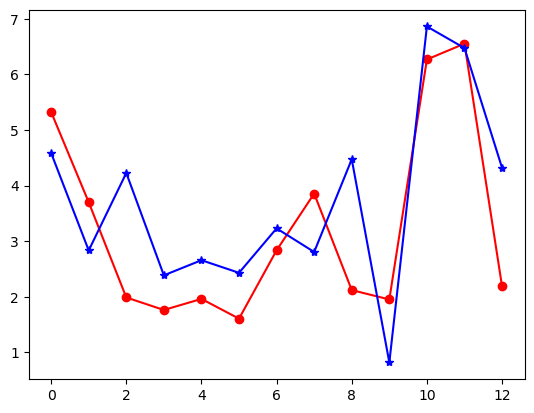

 train loss: 0.2287490678685052 validation loss: -0.05773911625146866
 train loss: 0.07164421656302043 validation loss: 0.27351832389831543
 train loss: 0.058150944273386684 validation loss: 0.6083849668502808
 train loss: 0.04574399406888655 validation loss: 0.5661510825157166
 train loss: 0.03672738756452288 validation loss: 0.34768760204315186
 train loss: 0.2756567742143359 validation loss: 0.47607263922691345
 train loss: 0.07525776805622238 validation loss: 0.10499069094657898
 train loss: 0.052256080082484654 validation loss: 0.5609769821166992
 train loss: 0.04130120048565524 validation loss: 0.4679814577102661
 train loss: 0.025125761330127717 validation loss: 0.5115703344345093
63 :  0.38186676800251007 [0.40172263979911804, 0.3620108962059021]
tensor(0.2045)


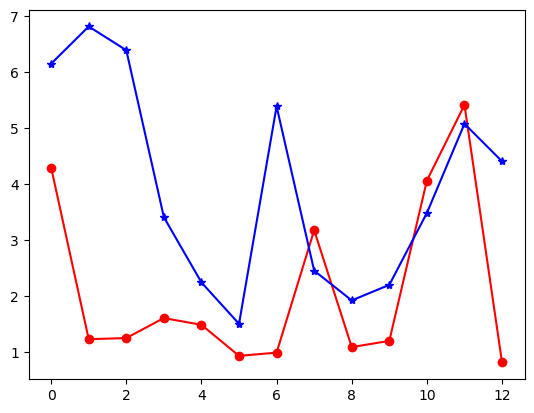

 train loss: 0.45488746762275695 validation loss: 0.030811920762062073
 train loss: 0.12397449910640716 validation loss: 0.5174808502197266
 train loss: 0.07728595563343593 validation loss: 0.37498190999031067
 train loss: 0.06789265743323734 validation loss: 0.32644394040107727
 train loss: 0.06825552423085485 validation loss: 0.3510705530643463
 train loss: 0.35580315717629024 validation loss: 0.6207729578018188
 train loss: 0.09451895228454045 validation loss: 0.45673972368240356
 train loss: 0.08325204423495701 validation loss: 0.22783401608467102
 train loss: 0.06284387792859758 validation loss: 0.26434817910194397
 train loss: 0.04341222457587719 validation loss: 0.2174922227859497
64 :  0.13657225854694843 [0.31371009349823, -0.040565576404333115]
tensor(0.2809)


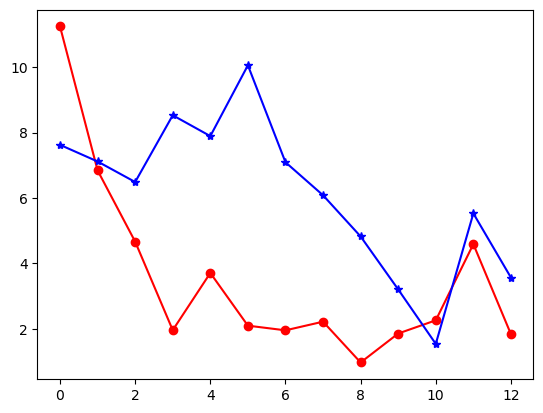

 train loss: 0.6864266020911081 validation loss: 0.024583881720900536
 train loss: 0.1429432796580451 validation loss: 0.295794278383255
 train loss: 0.09371540972164699 validation loss: 0.6480529308319092
 train loss: 0.07111744300595352 validation loss: 0.44827669858932495
 train loss: 0.0514923380953925 validation loss: 0.2626705467700958
 train loss: 0.5757182657718658 validation loss: -0.31417715549468994
 train loss: 0.1302346327475139 validation loss: 0.36392053961753845
 train loss: 0.09642572913851057 validation loss: 0.17167209088802338
 train loss: 0.06982231310435703 validation loss: 0.4992295205593109
 train loss: 0.06127255399312292 validation loss: 0.3712979257106781
65 :  0.5293140411376953 [0.5302069783210754, 0.5284211039543152]
tensor(0.6592)


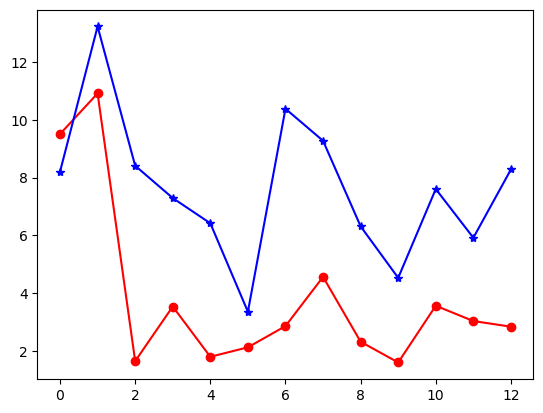

 train loss: 0.29418609440326693 validation loss: -0.12923942506313324
 train loss: 0.082578016604696 validation loss: 0.7127613425254822
 train loss: 0.06046227860663619 validation loss: 0.6109532713890076
 train loss: 0.047499009860413416 validation loss: 0.5653662085533142
 train loss: 0.04028241144759315 validation loss: 0.28380483388900757
 train loss: 0.46333365270069665 validation loss: -0.1111028641462326
 train loss: 0.08573717581374304 validation loss: 0.5999680757522583
 train loss: 0.061911159647362574 validation loss: 0.5597345232963562
 train loss: 0.04084526066269193 validation loss: 0.473048597574234
 train loss: 0.03915892775569643 validation loss: 0.5562471747398376
66 :  0.5477709472179413 [0.5400570034980774, 0.5554848909378052]
tensor(0.5019)


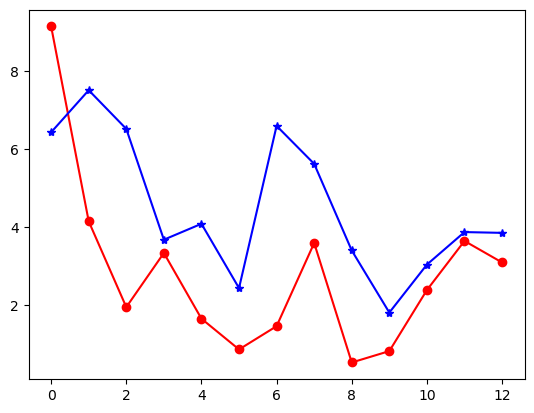

 train loss: 0.18845534324645996 validation loss: 0.25381314754486084
 train loss: 0.07989005999905723 validation loss: -0.06864896416664124
 train loss: 0.057505688071250914 validation loss: -0.1344054937362671
 train loss: 0.04053631680352347 validation loss: 0.061700161546468735
 train loss: 0.04123156863663878 validation loss: 0.44329121708869934
 train loss: 0.3519110964877265 validation loss: 0.13755105435848236
 train loss: 0.08393712448222297 validation loss: 0.20179685950279236
 train loss: 0.07081295081547329 validation loss: 0.18372678756713867
 train loss: 0.05959520584770611 validation loss: 0.14992083609104156
 train loss: 0.04879779836961201 validation loss: 0.04772531986236572
67 :  0.20273809134960175 [0.20527951419353485, 0.20019666850566864]
tensor(0.2303)


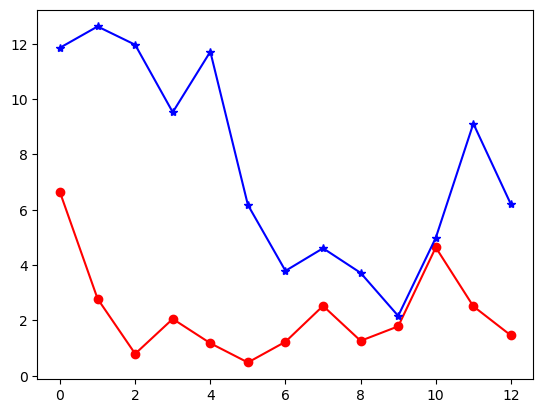

 train loss: 0.48130432282175334 validation loss: 0.27482154965400696
 train loss: 0.09927724131516048 validation loss: 0.5282908082008362
 train loss: 0.09569501749106817 validation loss: 0.4561857581138611
 train loss: 0.07438975125551224 validation loss: 0.38935351371765137
 train loss: 0.06887977442571096 validation loss: 0.3013436198234558
 train loss: 0.3456350641591208 validation loss: 0.15988139808177948
 train loss: 0.09092788738863809 validation loss: -0.1760731041431427
 train loss: 0.08310476914048195 validation loss: 0.6489130854606628
 train loss: 0.05523841849395207 validation loss: 0.5413854122161865
 train loss: 0.04366521931120328 validation loss: 0.59983891248703
68 :  0.5608519166707993 [0.6529250144958496, 0.4687788188457489]
tensor(0.6838)


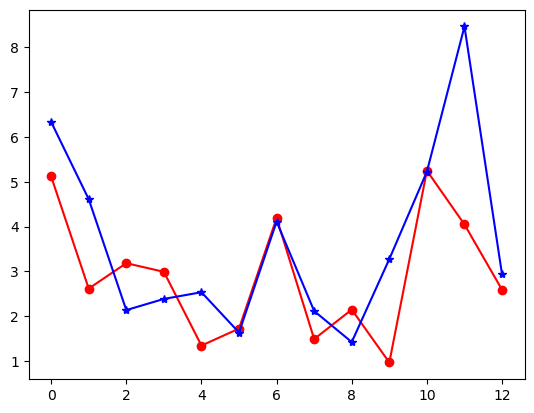

 train loss: 0.2685315012931824 validation loss: -0.3793713450431824
 train loss: 0.11616382002830505 validation loss: -0.16457852721214294
 train loss: 0.08923974015883036 validation loss: 0.032720427960157394
 train loss: 0.07723031331385885 validation loss: -0.3441687524318695
 train loss: 0.04653386633310999 validation loss: -0.25187253952026367
 train loss: 0.33743329899651664 validation loss: -0.17267575860023499
 train loss: 0.12032133340835571 validation loss: -0.2636808454990387
 train loss: 0.07409582755395344 validation loss: -0.5932135581970215
 train loss: 0.06684036723205021 validation loss: -0.07602594047784805
 train loss: 0.04787068750177111 validation loss: -0.36817729473114014
69 :  -0.07108082808554173 [-0.03436360880732536, -0.10779804736375809]
tensor(-0.2103)


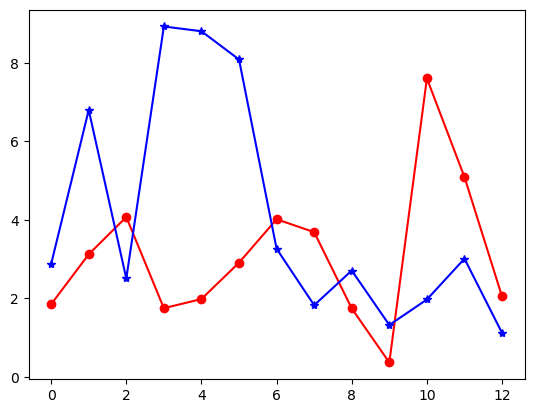

 train loss: 0.6363043180533818 validation loss: 0.11904006451368332
 train loss: 0.09761575077261243 validation loss: 0.3543962240219116
 train loss: 0.08049689084291459 validation loss: 0.4256109893321991
 train loss: 0.06947383795465742 validation loss: 0.3800612688064575
 train loss: 0.05429396757057735 validation loss: 0.3589010238647461
 train loss: 0.3657594693558557 validation loss: 0.30900460481643677
 train loss: 0.10504921525716782 validation loss: 0.48182612657546997
 train loss: 0.08258001921432359 validation loss: 0.4780735671520233
 train loss: 0.07711471265980176 validation loss: 0.6885954737663269
 train loss: 0.05729740027870451 validation loss: 0.37773215770721436
70 :  0.4295744001865387 [0.48401087522506714, 0.37513792514801025]
tensor(0.5203)


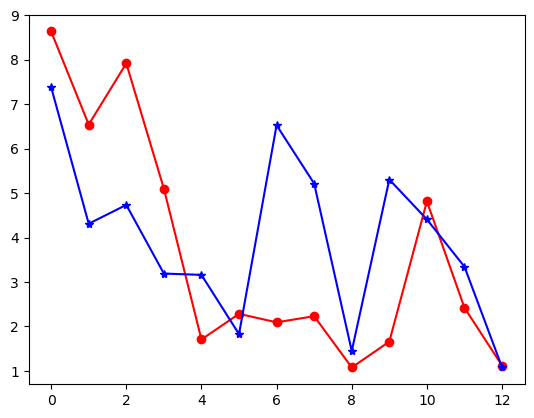

 train loss: 0.20218188571078435 validation loss: -0.01902419701218605
 train loss: 0.129744211265019 validation loss: -0.08038432151079178
 train loss: 0.09757049019847597 validation loss: 0.19675011932849884
 train loss: 0.06506196962935584 validation loss: -0.13030211627483368
 train loss: 0.048350987157651355 validation loss: -0.2468971461057663
 train loss: 0.32320244780608587 validation loss: -0.013335306197404861
 train loss: 0.10707864463329315 validation loss: 0.14574196934700012
 train loss: 0.06099616422184876 validation loss: -0.3395327031612396
 train loss: 0.05749676802328655 validation loss: -0.3693154752254486
 train loss: 0.05150141258324895 validation loss: -0.1577298939228058
71 :  -0.13243324495851994 [0.05224232003092766, -0.31710880994796753]
tensor(-0.0335)


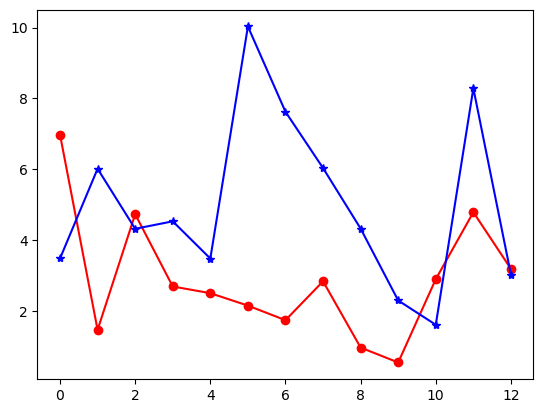

 train loss: 0.37208368607929776 validation loss: -0.1021696999669075
 train loss: 0.08730782291718892 validation loss: 0.4463852047920227
 train loss: 0.06716057807207107 validation loss: 0.5863551497459412
 train loss: 0.06210004240274429 validation loss: 0.5763368606567383
 train loss: 0.04636214045541627 validation loss: 0.1949111521244049
 train loss: 0.3526509953396661 validation loss: 0.3943113386631012
 train loss: 0.08343538450343269 validation loss: 0.543036699295044
 train loss: 0.0647394870008741 validation loss: 0.6966521143913269
 train loss: 0.05263491254299879 validation loss: 0.705186665058136
 train loss: 0.05257972457579204 validation loss: 0.7532289028167725
72 :  0.5168634057044983 [0.37969541549682617, 0.6540313959121704]
tensor(0.7149)


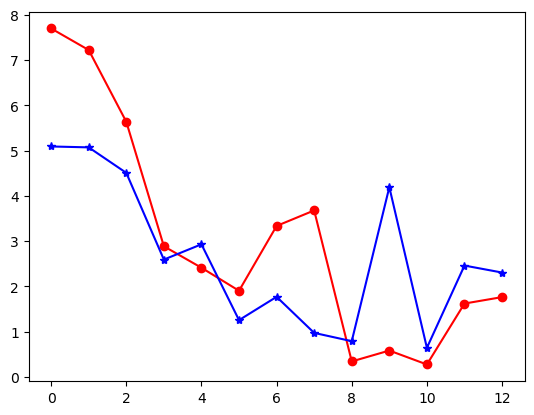

 train loss: 0.25868170080440384 validation loss: 0.18468956649303436
 train loss: 0.0827839657664299 validation loss: 0.5936498641967773
 train loss: 0.0493137104170663 validation loss: 0.5254658460617065
 train loss: 0.03731999333415713 validation loss: 0.49201348423957825
 train loss: 0.03304419219493866 validation loss: -0.003981537651270628
 train loss: 0.2694091452019555 validation loss: 0.5945291519165039
 train loss: 0.07278637055839811 validation loss: 0.5951923727989197
 train loss: 0.04863124138542584 validation loss: 0.3379784822463989
 train loss: 0.045550902507134845 validation loss: 0.5748891830444336
 train loss: 0.03487331893827234 validation loss: 0.4357894957065582
73 :  0.37914805114269257 [0.37700992822647095, 0.3812861740589142]
tensor(0.7376)


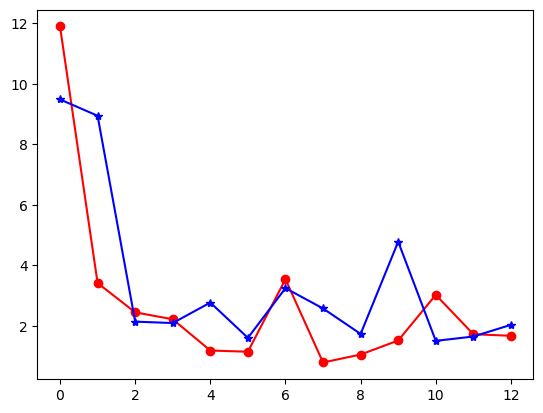

 train loss: 1.1637609558446067 validation loss: 0.11350902915000916
 train loss: 0.10931606377874102 validation loss: 0.46756866574287415
 train loss: 0.10736853522913796 validation loss: 0.6815578937530518
 train loss: 0.07847626613719123 validation loss: 0.35746094584465027
 train loss: 0.057559615799358914 validation loss: 0.1368323266506195
 train loss: 0.22728904102529798 validation loss: -0.022208090871572495
 train loss: 0.09314678715808052 validation loss: 0.1415681540966034
 train loss: 0.08072653583117893 validation loss: 0.23440074920654297
 train loss: 0.05331719145178795 validation loss: 0.031958095729351044
 train loss: 0.03707551801843303 validation loss: 0.14991021156311035
74 :  -0.02897445112466812 [0.12033700942993164, -0.17828591167926788]
tensor(-0.1098)


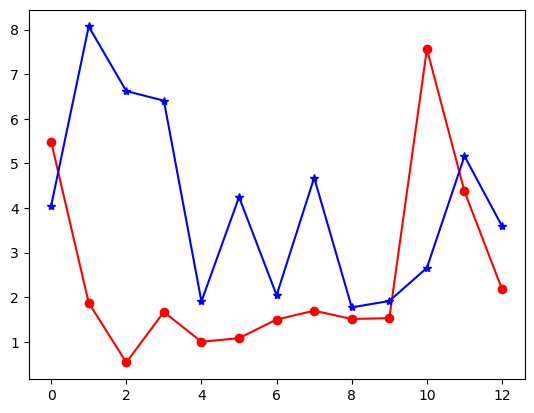

 train loss: 0.6707661024161747 validation loss: -0.16107749938964844
 train loss: 0.15291721278003284 validation loss: 0.0028839295264333487
 train loss: 0.09346441456249782 validation loss: 0.4899073839187622
 train loss: 0.07171998513596399 validation loss: 0.26561814546585083
 train loss: 0.06118482734475817 validation loss: 0.4564269483089447
 train loss: 0.3358293090547834 validation loss: -0.4706384539604187
 train loss: 0.11805295263017927 validation loss: -0.1718134582042694
 train loss: 0.11874121108225413 validation loss: 0.5092046856880188
 train loss: 0.08115163519978523 validation loss: 0.5956494212150574
 train loss: 0.057645286513226375 validation loss: 0.35420724749565125
75 :  0.5899622440338135 [0.6568361520767212, 0.5230883359909058]
tensor(0.3539)


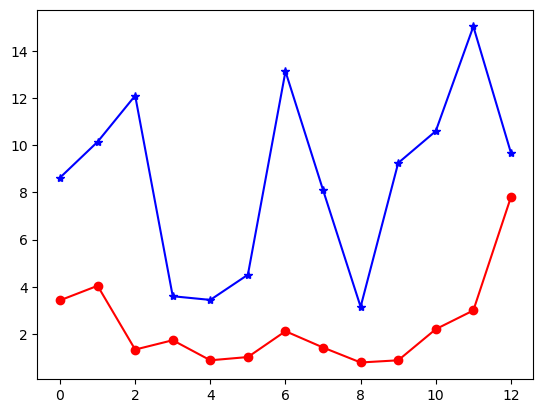

 train loss: 0.509869292804173 validation loss: -0.056971900165081024
 train loss: 0.10320286048310144 validation loss: 0.5603992342948914
 train loss: 0.08875189104250499 validation loss: 0.6411382555961609
 train loss: 0.07375673736844744 validation loss: 0.5633513927459717
 train loss: 0.05410716842327799 validation loss: 0.7070115804672241
 train loss: 0.38474929673331126 validation loss: 0.42447778582572937
 train loss: 0.12345639254365648 validation loss: 0.6384033560752869
 train loss: 0.09832402638026647 validation loss: 0.6696119904518127
 train loss: 0.06325875696327005 validation loss: 0.5821569561958313
 train loss: 0.05160146738801684 validation loss: 0.5329006910324097
76 :  0.6692852079868317 [0.7004916071891785, 0.6380788087844849]
tensor(0.5957)


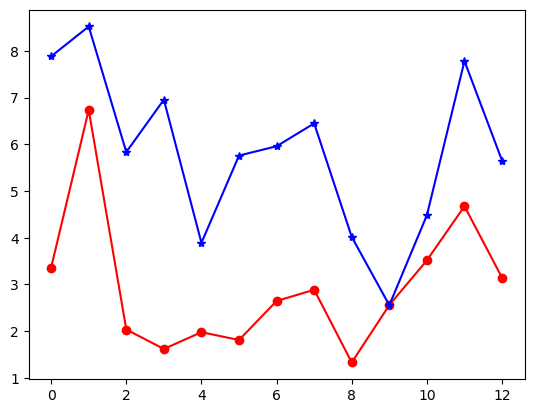

 train loss: 0.18792349419423512 validation loss: 0.26426199078559875
 train loss: 0.08023299702576228 validation loss: 0.25189539790153503
 train loss: 0.05248980037868023 validation loss: 0.5690646171569824
 train loss: 0.04660264179110527 validation loss: 0.4953172206878662
 train loss: 0.031571631346430096 validation loss: 0.47372913360595703
 train loss: 0.265412300825119 validation loss: -0.24167567491531372
 train loss: 0.06269293081547533 validation loss: 0.3008131980895996
 train loss: 0.05815464024032865 validation loss: 0.706117570400238
 train loss: 0.04027763168726649 validation loss: 0.511955201625824
 train loss: 0.03507307275597538 validation loss: 0.3234429359436035
77 :  0.5813219994306564 [0.4912905991077423, 0.6713533997535706]
tensor(0.5132)


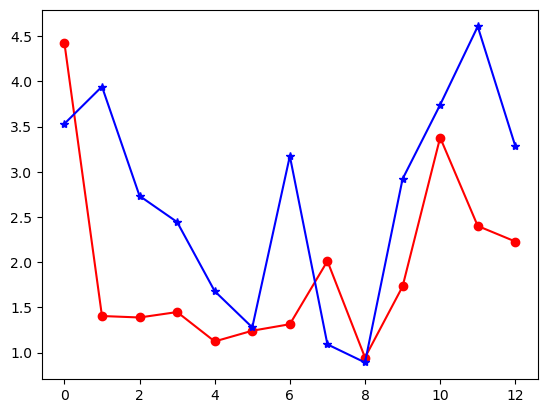

 train loss: 0.4283450497048242 validation loss: 0.40169674158096313
 train loss: 0.107894088860069 validation loss: 0.48609012365341187
 train loss: 0.09273019326584679 validation loss: 0.43583473563194275
 train loss: 0.07329372188874654 validation loss: 0.6842281222343445
 train loss: 0.05557943513350827 validation loss: 0.433420330286026
 train loss: 0.21111825449126106 validation loss: -0.04650771617889404
 train loss: 0.1258476142372404 validation loss: 0.523469865322113
 train loss: 0.08504295945167542 validation loss: 0.5332379341125488
 train loss: 0.08624511339834758 validation loss: 0.31900039315223694
 train loss: 0.07875949740409852 validation loss: 0.2327887862920761
78 :  0.1541893631219864 [0.38649678230285645, -0.07811805605888367]
tensor(0.6401)


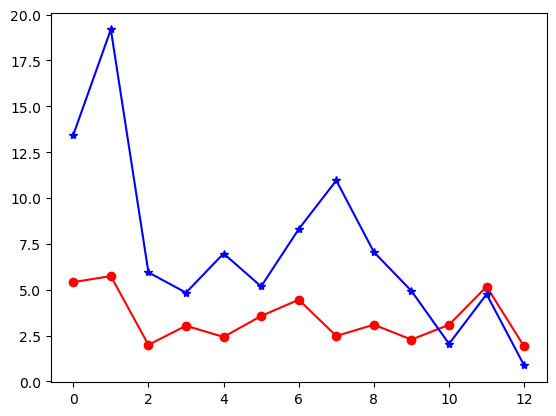

 train loss: 0.4274664891617639 validation loss: 0.10542101413011551
 train loss: 0.08637992787574018 validation loss: 0.5384782552719116
 train loss: 0.07466623112559319 validation loss: 0.45325037837028503
 train loss: 0.05525712317654065 validation loss: 0.12150489538908005
 train loss: 0.05007230918854475 validation loss: 0.4220241904258728
 train loss: 0.36614460391657694 validation loss: 0.2550423741340637
 train loss: 0.10575608536601067 validation loss: 0.560631513595581
 train loss: 0.06440570684415954 validation loss: 0.40366458892822266
 train loss: 0.06674063482454845 validation loss: 0.39365053176879883
 train loss: 0.041994539541857584 validation loss: 0.4114654064178467
79 :  0.22906459122896194 [0.19021426141262054, 0.26791492104530334]
tensor(0.3118)


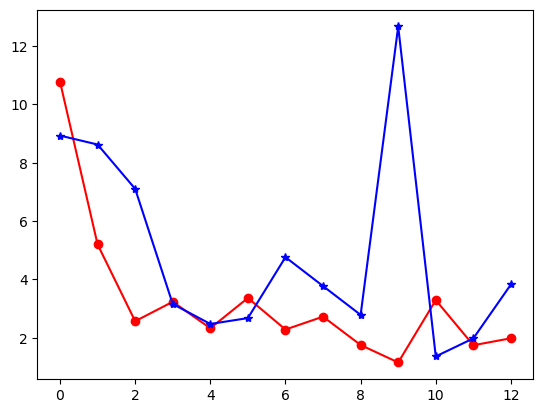

 train loss: 0.4078796514442989 validation loss: -0.29587656259536743
 train loss: 0.09687398650816509 validation loss: 0.5579851269721985
 train loss: 0.0796521367771285 validation loss: 0.3073986768722534
 train loss: 0.0594700100166457 validation loss: 0.1984812170267105
 train loss: 0.049300608783960344 validation loss: 0.14962933957576752
 train loss: 0.6434549144336156 validation loss: -0.19433949887752533
 train loss: 0.1147406273654529 validation loss: 0.3337306082248688
 train loss: 0.08568828042064394 validation loss: 0.5670796036720276
 train loss: 0.06923298452581678 validation loss: 0.5113688111305237
 train loss: 0.06605000070163182 validation loss: 0.3481714129447937
80 :  0.40545859932899475 [0.33173617720603943, 0.4791810214519501]
tensor(0.6460)


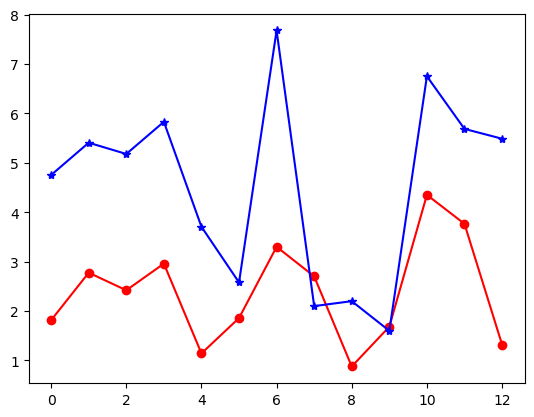

 train loss: 0.3125871815851757 validation loss: 0.46188125014305115
 train loss: 0.11610880685704095 validation loss: 0.027777783572673798
 train loss: 0.0814636190022741 validation loss: 0.3939775228500366
 train loss: 0.06436606922319957 validation loss: 0.4805452525615692
 train loss: 0.046220201573201586 validation loss: 0.21630804240703583
 train loss: 0.6359059963907514 validation loss: -0.09820129722356796
 train loss: 0.09676042912261827 validation loss: 0.19278423488140106
 train loss: 0.06736460030078888 validation loss: 0.21412307024002075
 train loss: 0.05944412446447781 validation loss: 0.09758643805980682
 train loss: 0.055564137867518834 validation loss: 0.438610702753067
81 :  0.5273708701133728 [0.3171141743659973, 0.7376275658607483]
tensor(0.1973)


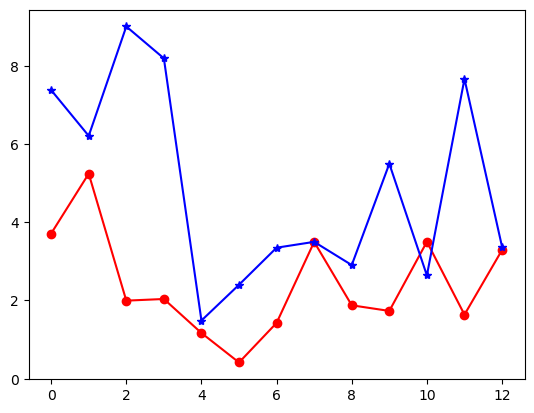

 train loss: 0.41565398722887037 validation loss: -0.02120954357087612
 train loss: 0.09082976302930287 validation loss: 0.21149185299873352
 train loss: 0.07014757692813874 validation loss: -0.01750999130308628
 train loss: 0.05104401590568679 validation loss: -0.32549363374710083
 train loss: 0.04944316010390009 validation loss: -0.4577282667160034
 train loss: 0.28348469340375493 validation loss: -0.025390222668647766
 train loss: 0.07849178314208985 validation loss: -0.048629406839609146
 train loss: 0.05355793769870486 validation loss: 0.40087199211120605
 train loss: 0.05835447838263852 validation loss: 0.2622626721858978
 train loss: 0.03715587620224271 validation loss: -0.06757144629955292
82 :  -0.07890070602297783 [-0.08040692657232285, -0.07739448547363281]
tensor(-0.2823)


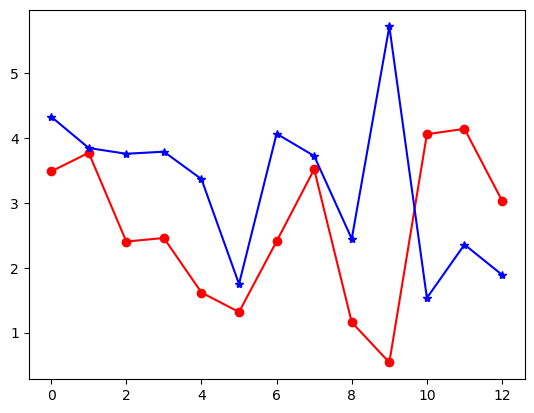

 train loss: 0.677877676486969 validation loss: -0.12113869190216064
 train loss: 0.1348176028047289 validation loss: 0.25748270750045776
 train loss: 0.10198985316923687 validation loss: 0.35461530089378357
 train loss: 0.07066646005426135 validation loss: 0.39742720127105713
 train loss: 0.06831646114587783 validation loss: 0.2846764624118805
 train loss: 0.39932162506239754 validation loss: -0.09329358488321304
 train loss: 0.12978655653340476 validation loss: -0.07502199709415436
 train loss: 0.0912900491484574 validation loss: -0.21678948402404785
 train loss: 0.10269070033516203 validation loss: 0.30504313111305237
 train loss: 0.03687686409269061 validation loss: -0.11901520192623138
83 :  0.1258225804194808 [0.27944889664649963, -0.027803735807538033]
tensor(0.0331)


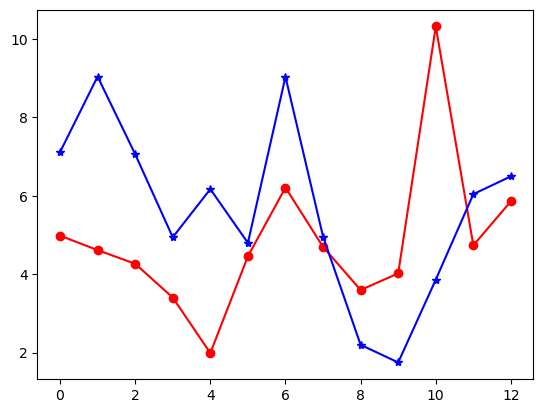

 train loss: 0.3572392659527915 validation loss: 0.028099916875362396
 train loss: 0.0960367658308574 validation loss: 0.1952705681324005
 train loss: 0.06772568012986864 validation loss: -0.15493421256542206
 train loss: 0.058287182876041954 validation loss: 0.3651094436645508
 train loss: 0.05816286706498691 validation loss: 0.43648356199264526
 train loss: 0.4175018923623221 validation loss: -0.011237657628953457
 train loss: 0.10516607676233564 validation loss: 0.7986665368080139
 train loss: 0.08633093876498087 validation loss: 0.6942970752716064
 train loss: 0.0632544600537845 validation loss: 0.7783116102218628
 train loss: 0.046591407379933766 validation loss: 0.5243513584136963
84 :  0.7106122076511383 [0.6217885613441467, 0.7994358539581299]
tensor(0.6428)


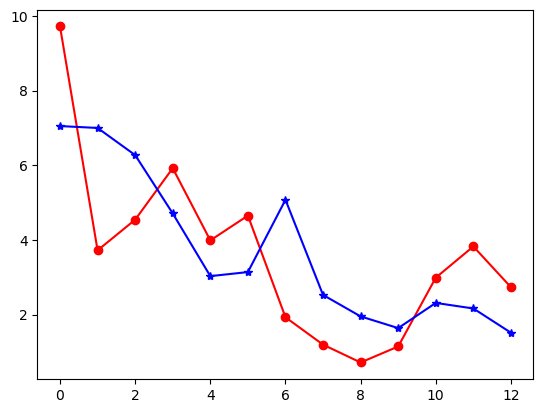

 train loss: 0.27460863419941495 validation loss: 0.08064916729927063
 train loss: 0.08757409432104656 validation loss: 0.22180740535259247
 train loss: 0.07404135806219918 validation loss: 0.06317567080259323
 train loss: 0.04222151498709406 validation loss: 0.03495959937572479
 train loss: 0.057167643681168556 validation loss: 0.12355593591928482
 train loss: 0.3587097082819257 validation loss: 0.3783663809299469
 train loss: 0.0919993988105229 validation loss: 0.21272294223308563
 train loss: 0.07572062600936208 validation loss: -0.43495485186576843
 train loss: 0.057021406186478475 validation loss: 0.4452236592769623
 train loss: 0.045252831705978935 validation loss: 0.10164792090654373
85 :  0.263943649828434 [0.1741146594285965, 0.3537726402282715]
tensor(-0.2713)


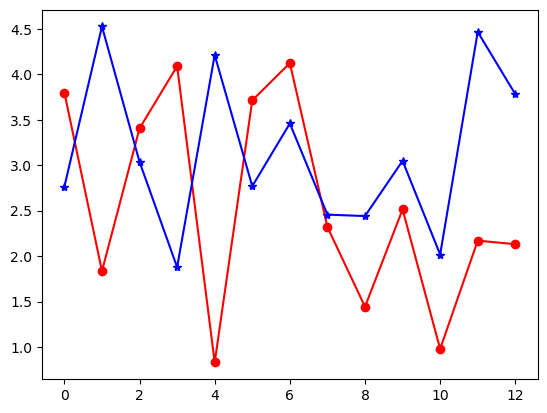

 train loss: 0.3243839966399329 validation loss: 0.027548424899578094
 train loss: 0.08058168143033981 validation loss: 0.4657578766345978
 train loss: 0.07250945770314761 validation loss: 0.6686062812805176
 train loss: 0.049717325557555474 validation loss: 0.3849022686481476
 train loss: 0.04188441208430699 validation loss: 0.35774147510528564
 train loss: 0.42594134977885656 validation loss: 0.17169514298439026
 train loss: 0.08431336102741105 validation loss: -0.3153841197490692
 train loss: 0.07169434981686729 validation loss: 0.3520740866661072
 train loss: 0.05451015084981918 validation loss: 0.4001830816268921
 train loss: 0.05212741047143936 validation loss: 0.38013261556625366
86 :  0.43582530319690704 [0.49035534262657166, 0.38129526376724243]
tensor(0.2228)


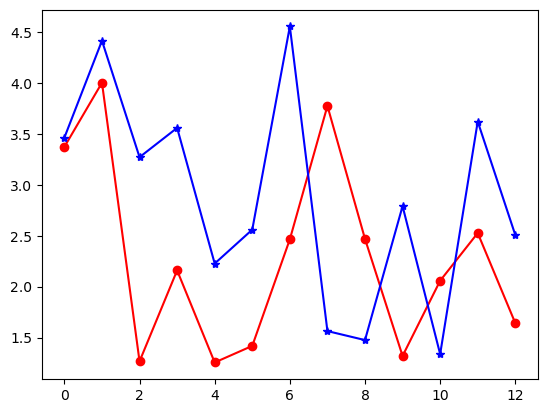

 train loss: 0.36531023383140565 validation loss: 0.18430237472057343
 train loss: 0.08814061198915754 validation loss: 0.4246206283569336
 train loss: 0.06503597519227437 validation loss: 0.6185652613639832
 train loss: 0.04262324571609497 validation loss: 0.26135262846946716
 train loss: 0.043829735794237684 validation loss: 0.42236432433128357
 train loss: 0.4957601972988674 validation loss: 0.18964606523513794
 train loss: 0.08574649010385786 validation loss: 0.5199624300003052
 train loss: 0.06055531182459423 validation loss: 0.43225783109664917
 train loss: 0.050343964568206244 validation loss: 0.38795313239097595
 train loss: 0.040641287341713905 validation loss: 0.7736991047859192
87 :  0.41670261323451996 [0.5093441009521484, 0.3240611255168915]
tensor(-0.3260)


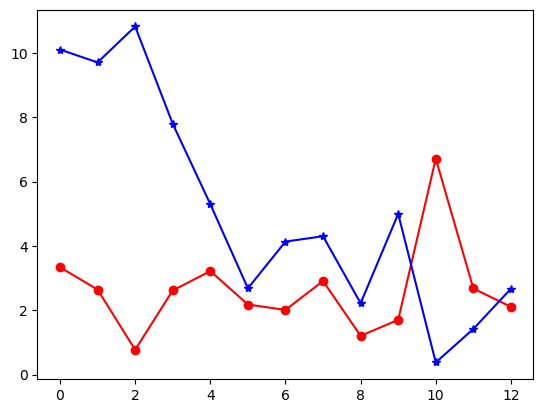

 train loss: 0.4188908074583326 validation loss: 0.4075382947921753
 train loss: 0.11837909860270364 validation loss: 0.5790571570396423
 train loss: 0.09104282174791609 validation loss: 0.4410746097564697
 train loss: 0.06276030484586954 validation loss: 0.40769821405410767
 train loss: 0.04948894072856222 validation loss: 0.3483114540576935
 train loss: 0.33997413728918346 validation loss: 0.13097381591796875
 train loss: 0.11054311980094228 validation loss: 0.042069099843502045
 train loss: 0.06682953557797841 validation loss: 0.27575358748435974
 train loss: 0.05625371102775846 validation loss: 0.2013973444700241
 train loss: 0.049109417838709694 validation loss: 0.062240295112133026
88 :  0.3097805753350258 [0.4880319833755493, 0.13152916729450226]
tensor(-0.1369)


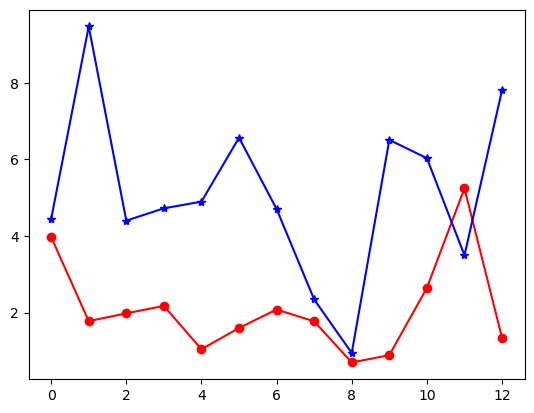

In [87]:
ex_list = [330,48,21736,18900,11814,22401]
device = torch.device("cuda:1")
nor_sta_fes = nor_sta_fes.to(device)
x_train = x_train.to(device)
x_test = x_test.to(device)


for ex_id in range(44,45):

    #batch_size = 10
    train_data = torch.utils.data.TensorDataset(x_train[:,:,:,ex_id], y_train[:,ex_id])
    train_iter = torch.utils.data.DataLoader(train_data, batch_size, shuffle=True)
    val_data = torch.utils.data.TensorDataset(x_test[:,:,:,ex_id], y_test[:,ex_id])
    val_iter = torch.utils.data.DataLoader(val_data, batch_size)
    #test_data = torch.utils.data.TensorDataset(x_test_d[:,:,:,ex_id], y_test_d[:,ex_id])
    #test_iter = torch.utils.data.DataLoader(test_data, batch_size)
    vals = []
    for j in range(2):
        tcn = TCN(num_inputs, num_channels, kernel_size, dropout).to(device)
        #print(tcn)
        criterion = nn.MSELoss()  # 均方误差损失函数
        optimizer = torch.optim.Adam(tcn.parameters(), lr=0.002,weight_decay = 5e-5)  # Adam优化器
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.85)
        
        loss = nn.MSELoss()
        min_val_loss = np.inf
        for epoch in range(1, 100+1):
            l_sum, n = 0.0, 0
            tcn.train()
            for x, y in train_iter:
                x,y = x.to(device),y.to(device)
                y_pred = tcn(x,nor_sta_fes[ex_id,:]).view(-1,)
                #print(y_pred.shape,y.shape)
                l = loss(y_pred, y)
                optimizer.zero_grad()
                l.backward()
                optimizer.step()
                l_sum += l.item() * y.shape[0]
                n += y.shape[0]
            scheduler.step()
            val_pre = tcn(x_test[:,:,:,ex_id],nor_sta_fes[ex_id,:]).view(-1,).cpu()
            #train_loss = 
            #val_loss = torch_corre(val_pre,y_val[:,ex_id])
            #print(val_pre.shape,y_val[:,ex_id].shape)
            val_loss = torch_corre(val_pre,y_test[:,ex_id])
            if epoch%20 ==1:
                print(" train loss:",l_sum / n,"validation loss:",val_loss.item())
            
        vals.append(val_loss.item())
    print(ex_id,': ', np.mean(vals),vals)
    outputs = tcn(x_test[:,:,:,ex_id],nor_sta_fes[ex_id,:]).cpu().detach().numpy()
    y_label1 = y_test[:,ex_id].cpu().detach().numpy()
    re_y_pre = (np.exp(2*outputs)-1).reshape((-1,1))
    re_y_real = (np.exp(2*y_label1)-1).reshape((-1,1))
    print(torch_corre(torch.tensor(re_y_pre),torch.tensor(re_y_real)))
    
    x = range(y_label1.shape[0])
    import matplotlib.pyplot as plt
    plt.plot(x, re_y_pre,marker='o', linestyle='-', color='r')  # 使用红色线和圆形标记点
    plt.plot(x, re_y_real,marker='*', linestyle='-', color='b')  # 使用红色线和圆形标记点
    #plt.plot(x, x_train[:,1,-1,1234].cpu().detach().numpy(),marker='o', linestyle='-', color='y')  # 使用红色线和圆形标记点
    plt.show()

In [59]:
for x_batch,y_batch in train_data:
    print("x_batch - 最大值:", torch.max(x_batch).item())
    print("x_batch - 最小值:", torch.min(x_batch).item())
    print("y_batch - 最大值:", torch.max(y_batch).item())
    print("y_batch - 最小值:", torch.min(y_batch).item())
    
    if torch.isnan(x_batch).any() or torch.isnan(y_batch).any():
        print("批次数据中存在NaN值")
        #break  # 如果发现NaN值，中断循环
    '''
    if torch.isnan(y_batch).any():
        num_nan_y = torch.isnan(y_batch).sum().item()
        print(f"y_batch中存在 {num_nan_y} 个NaN值")
    '''

x_batch - 最大值: 15622.734375
x_batch - 最小值: -311.820068359375
y_batch - 最大值: 1.3584126234054565
y_batch - 最小值: 0.43939366936683655
x_batch - 最大值: 15390.5078125
x_batch - 最小值: -311.820068359375
y_batch - 最大值: 1.3216265439987183
y_batch - 最小值: 0.5553635358810425
x_batch - 最大值: 15685.7939453125
x_batch - 最小值: -298.1639404296875
y_batch - 最大值: 1.3416218757629395
y_batch - 最小值: 0.5663517117500305
x_batch - 最大值: 16034.3759765625
x_batch - 最小值: -188.077880859375
y_batch - 最大值: 1.3255894184112549
y_batch - 最小值: 0.5000405311584473
x_batch - 最大值: 16129.8544921875
x_batch - 最小值: -188.077880859375
y_batch - 最大值: 1.3709657192230225
y_batch - 最小值: 0.674501359462738
x_batch - 最大值: 16283.88671875
x_batch - 最小值: -175.4310302734375
y_batch - 最大值: 1.3431135416030884
y_batch - 最小值: 0.6146968603134155
x_batch - 最大值: 16455.078125
x_batch - 最小值: -175.4310302734375
y_batch - 最大值: 1.338744878768921
y_batch - 最小值: 0.5766646265983582
x_batch - 最大值: 16471.279296875
x_batch - 最小值: -48.3597412109375
y_batch - 最大值: 1